# 1. IMPORT THƯ VIỆN

In [6]:
import requests
from bs4 import BeautifulSoup
import os
import csv
from concurrent.futures import ThreadPoolExecutor
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt

# 2. CRAWL DỮ LIỆU

## 2.1 Crawl điểm thi THPTQG [2018 - 2023] 

In [7]:
ID_TO_PROVINCE_DICTIONARY = {
    '01': 'Thành phố Hà Nội',
    '02': 'Thành phố Hồ Chí Minh',
    '03': 'Thành phố Hải Phòng',
    '04': 'Thành phố Đà Nẵng',
    '05': 'Tỉnh Hà Giang',
    '06': 'Tỉnh Cao Bằng',
    '07': 'Tỉnh Lai Châu',
    '08': 'Tỉnh Lào Cai',
    '09': 'Tỉnh Tuyên Quang',
    '10': 'Lạng Sơn',
    '11': 'Tỉnh Bắc Kạn',
    '12': 'Tỉnh Thái Nguyên',
    '13': 'Tỉnh Yên Bái',
    '14': 'Tỉnh Sơn La',
    '15': 'Tỉnh Phú Thọ',
    '16': 'Tỉnh Vĩnh Phúc',
    '17': 'Tỉnh Quảng Ninh',
    '18': 'Tỉnh Bắc Giang',
    '19': 'Tỉnh Bắc Ninh',
    '21': 'Tỉnh Hải Dương',
    '22': 'Tỉnh Hưng Yên',
    '23': 'Tỉnh Hòa Bình',
    '24': 'Tỉnh Hà Nam',
    '25': 'Tỉnh Nam Định',
    '26': 'Tỉnh Thái Bình',
    '27': 'Tỉnh Ninh Bình',
    '28': 'Tỉnh Thanh Hóa',
    '29': 'Tỉnh Nghệ An',
    '30': 'Tỉnh Hà Tĩnh',
    '31': 'Tỉnh Quảng Bình',
    '32': 'Tỉnh Quảng Trị',
    '33': 'Tỉnh Thừa Thiên - Huế',
    '34': 'Tỉnh Quảng Nam',
    '35': 'Tỉnh Quảng Ngãi',
    '36': 'Tỉnh Kon Tum',
    '37': 'Tỉnh Bình Định',
    '38': 'Tỉnh Gia Lai',
    '39': 'Tỉnh Phú Yên',
    '40': 'Tỉnh Đắk Lắk',
    '41': 'Tỉnh Khánh Hòa',
    '42': 'Tỉnh Lâm Đồng',
    '43': 'Tỉnh Bình Phước',
    '44': 'Tỉnh Bình Dương',
    '45': 'Tỉnh Ninh Thuận',
    '46': 'Tỉnh Tây Ninh',
    '47': 'Tỉnh Bình Thuận',
    '48': 'Tỉnh Đồng Nai',
    '49': 'Tỉnh Long An',
    '50': 'Tỉnh Đồng Tháp',
    '51': 'Tỉnh An Giang',
    '52': 'Tỉnh Bà Rịa - Vũng Tàu',
    '53': 'Tỉnh Tiền Giang',
    '54': 'Tỉnh Kiên Giang',
    '55': 'Thành phố Cần Thơ',
    '56': 'Tỉnh Bến Tre',
    '57': 'Tỉnh Vĩnh Long',
    '58': 'Tỉnh Trà Vinh',
    '59': 'Tỉnh Sóc Trăng',
    '60': 'Tỉnh Bạc Liêu',
    '61': 'Tỉnh Cà Mau',
    '62': 'Tỉnh Điện Biên',
    '63': 'Tỉnh Đắk Nông',
    '64': 'Tỉnh Hậu Giang'
}

In [9]:
# bị lỗi HTTPS
PROVINCE_TO_ID_DICTIONARY = {province_name: province_id for province_id, province_name in ID_TO_PROVINCE_DICTIONARY.items()}

PROVINCE_LIST = list(ID_TO_PROVINCE_DICTIONARY.values())
YEARS = [2018, 2019, 2020, 2021, 2022, 2023]
CRAWL_FIELDS = ["Toán", "Ngữ văn", "Ngoại ngữ"]

def process_province(year_province):
    year, province = year_province
    student_count = 0
    for student_id in range(1, 10000):
        identification_number = PROVINCE_TO_ID_DICTIONARY[province] + '0' * (6 - len(str(student_id))) + str(student_id)
        url = f"https://diemthi.vnanet.vn/Home/SearchBySobaodanh?code={identification_number}&nam={year}"
        response = requests.get(url)
        data = response.json()
        if time.time() - start_time >= 10:
            break
        if "result" in data and len(data["result"]) > 0:
            result = data["result"][0]
            diem_toan = float(result.get("Toan", 0)) if result.get("Toan", "") != "" else 0
            diem_ngu_van = float(result.get("NguVan", 0)) if result.get("NguVan", "") != "" else 0
            diem_ngoai_ngu = float(result.get("NgoaiNgu", 0)) if result.get("NgoaiNgu", "") != "" else 0
            diem_trung_binh = (diem_toan + diem_ngu_van + diem_ngoai_ngu) / 3
            sbd = result.get("Code", "Không có thông tin")
            print(f"SBD: {sbd} Điểm toán: {diem_toan} Điểm văn: {diem_ngu_van} Điểm ngoại ngữ: {diem_ngoai_ngu}")
            student_count += 1
            if student_count == 1000:
                break

stop = False
start_time = time.time()

for year in YEARS:
    if stop == True:
        break
    for province in PROVINCE_LIST:
        process_province((year, province))
        stop = True
        break
print("Đã tạo các tệp CSV thành công!")


SBD: 01000019 Điểm toán: 4.8 Điểm văn: 5.75 Điểm ngoại ngữ: 4.8
SBD: 01000020 Điểm toán: 6.8 Điểm văn: 8.25 Điểm ngoại ngữ: 7.0
SBD: 01000021 Điểm toán: 5.6 Điểm văn: 8.0 Điểm ngoại ngữ: 6.4
SBD: 01000022 Điểm toán: 6.0 Điểm văn: 6.5 Điểm ngoại ngữ: 9.4
SBD: 01000023 Điểm toán: 4.8 Điểm văn: 6.75 Điểm ngoại ngữ: 7.8
SBD: 01000024 Điểm toán: 6.2 Điểm văn: 7.0 Điểm ngoại ngữ: 7.4
SBD: 01000025 Điểm toán: 3.4 Điểm văn: 7.0 Điểm ngoại ngữ: 5.4
SBD: 01000026 Điểm toán: 6.4 Điểm văn: 7.25 Điểm ngoại ngữ: 4.2
SBD: 01000027 Điểm toán: 6.2 Điểm văn: 7.5 Điểm ngoại ngữ: 7.6
SBD: 01000028 Điểm toán: 3.0 Điểm văn: 5.25 Điểm ngoại ngữ: 5.0
SBD: 01000029 Điểm toán: 5.4 Điểm văn: 5.0 Điểm ngoại ngữ: 8.0
SBD: 01000030 Điểm toán: 6.6 Điểm văn: 6.5 Điểm ngoại ngữ: 8.2
SBD: 01000031 Điểm toán: 5.0 Điểm văn: 5.5 Điểm ngoại ngữ: 6.0
SBD: 01000032 Điểm toán: 5.2 Điểm văn: 5.75 Điểm ngoại ngữ: 5.6
SBD: 01000033 Điểm toán: 7.6 Điểm văn: 8.25 Điểm ngoại ngữ: 7.0
SBD: 01000034 Điểm toán: 6.2 Điểm văn: 6.25 Điểm

## 2.2 Crawl data Dân số và mật độ dân số [2018 - 2022]

In [4]:
url = "https://pxweb.gso.gov.vn/pxweb/vi/D%c3%a2n%20s%e1%bb%91%20v%c3%a0%20lao%20%c4%91%e1%bb%99ng/D%c3%a2n%20s%e1%bb%91%20v%c3%a0%20lao%20%c4%91%e1%bb%99ng/V02.01.px/table/tableViewLayout1/?rxid=e6ed7618-f55b-49fd-a76b-5e7d2dee73e3"

# Khởi tạo trình duyệt
driver = webdriver.Chrome()  # Cần cài đặt Chrome WebDriver và thay đổi đường dẫn nếu cần thiết

# Mở trang web
driver.get(url)

# Chờ cho phần tử chứa dữ liệu được hiển thị trên trang (ví dụ: phần tử table)
try:
    element = WebDriverWait(driver, 100).until(
        EC.presence_of_element_located((By.TAG_NAME, "table"))
    )
    # Nếu phần tử được tìm thấy, lấy HTML của trang
    html_content = driver.page_source

    # Sử dụng BeautifulSoup để phân tích HTML
    soup = BeautifulSoup(html_content, "html.parser")

    # Tìm tất cả các thẻ table trong HTML
    tables = soup.find_all("table")

    # In ra dữ liệu bảng HTML
    for table in tables:
        print(table.prettify())

except Exception as e:
    print("Không tìm thấy phần tử chứa dữ liệu trên trang sau khi đã lọc.")
    print(e)

# Đóng trình duyệt
driver.quit()


<table class="px_setting_radiobuttonlist" id="ctl00_ctl00_ContentPlaceHolderMain_cphSettings_rblZeroOption">
 <tbody>
  <tr>
   <td>
    <input checked="checked" id="ctl00_ctl00_ContentPlaceHolderMain_cphSettings_rblZeroOption_0" name="ctl00$ctl00$ContentPlaceHolderMain$cphSettings$rblZeroOption" type="radio" value="ShowAll"/>
    <label for="ctl00_ctl00_ContentPlaceHolderMain_cphSettings_rblZeroOption_0">
     Show all rows
    </label>
   </td>
  </tr>
  <tr>
   <td>
    <input id="ctl00_ctl00_ContentPlaceHolderMain_cphSettings_rblZeroOption_1" name="ctl00$ctl00$ContentPlaceHolderMain$cphSettings$rblZeroOption" type="radio" value="NoZero"/>
    <label for="ctl00_ctl00_ContentPlaceHolderMain_cphSettings_rblZeroOption_1">
     Hide rows with only zeros
    </label>
   </td>
  </tr>
  <tr>
   <td>
    <input id="ctl00_ctl00_ContentPlaceHolderMain_cphSettings_rblZeroOption_2" name="ctl00$ctl00$ContentPlaceHolderMain$cphSettings$rblZeroOption" type="radio" value="NoZeroAndNil"/>
    <labe

![Hình ảnh lấy dữ liệu mật độ dân số và dân số trung bình](assets/density_and_population.jpg)

![Hình ảnh lấy dữ liệu mật độ dân số và dân số trung bình](assets/density_and_population2.jpg)

In [5]:
url = "https://pxweb.gso.gov.vn/pxweb/vi/D%c3%a2n%20s%e1%bb%91%20v%c3%a0%20lao%20%c4%91%e1%bb%99ng/D%c3%a2n%20s%e1%bb%91%20v%c3%a0%20lao%20%c4%91%e1%bb%99ng/V02.01.px/table/tableViewLayout1/?rxid=e6ed7618-f55b-49fd-a76b-5e7d2dee73e3"

# Khởi tạo trình duyệt
driver = webdriver.Chrome()  # Cần cài đặt Chrome WebDriver và thay đổi đường dẫn nếu cần thiết

# Mở trang web
driver.get(url)
data_of_provinces = {}
# Chờ cho phần tử chứa dữ liệu được hiển thị trên trang (ví dụ: phần tử table)
try:
    element = WebDriverWait(driver, 100).until(
        EC.presence_of_element_located((By.TAG_NAME, "table"))
    )
    # Nếu phần tử được tìm thấy, lấy HTML của trang
    html_content = driver.page_source

    # Sử dụng BeautifulSoup để phân tích HTML
    soup = BeautifulSoup(html_content, "html.parser")

    # Tìm tất cả các thẻ table trong HTML
    tables = soup.find_all("th", class_="layout1-table-stub layout1-table-stub1")

    # In ra dữ liệu bảng HTML
    for table in tables:
        # In ra tên của tỉnh
        province_name = table.text.strip()
        print("Tỉnh:", province_name)

        # Tìm hàng mẹ của thẻ <th> hiện tại
        parent_row = table.find_parent("tr")
        data_of_provinces[province_name] = []
        # Tìm tất cả các ô dữ liệu (<td>) trong hàng mẹ
        row_data = parent_row.find_all("td", class_="table-data-filled")
        
        # Duyệt qua từng ô dữ liệu
        for data in row_data:
            print("Dữ liệu:", data.text.strip())  # In ra nội dung của ô dữ liệu
            data_of_provinces[province_name].append(data.text.strip())
        print()  # In ra dòng trống để phân tách giữa các tỉnh

except Exception as e:
    print("Không tìm thấy phần tử chứa dữ liệu trên trang sau khi đã lọc.")
    print(e)

# Đóng trình duyệt
driver.quit()


Tỉnh: Hà Nội
Dữ liệu: 7.914,50
Dữ liệu: 2.356,49
Dữ liệu: 8.093,90
Dữ liệu: 2.410,00
Dữ liệu: 8.246,54
Dữ liệu: 2.454,00
Dữ liệu: 8.330,83
Dữ liệu: 2.480,00
Dữ liệu: 8.435,65
Dữ liệu: 2.511,00

Tỉnh: Vĩnh Phúc
Dữ liệu: 1.138,40
Dữ liệu: 921,63
Dữ liệu: 1.154,80
Dữ liệu: 934,00
Dữ liệu: 1.171,20
Dữ liệu: 948,00
Dữ liệu: 1.191,78
Dữ liệu: 964,00
Dữ liệu: 1.197,62
Dữ liệu: 969,00

Tỉnh: Bắc Ninh
Dữ liệu: 1.337,30
Dữ liệu: 1.625,50
Dữ liệu: 1.378,60
Dữ liệu: 1.676,00
Dữ liệu: 1.419,13
Dữ liệu: 1.725,00
Dữ liệu: 1.462,95
Dữ liệu: 1.778,00
Dữ liệu: 1.488,20
Dữ liệu: 1.809,00

Tỉnh: Quảng Ninh
Dữ liệu: 1.303,90
Dữ liệu: 211,05
Dữ liệu: 1.324,80
Dữ liệu: 214,00
Dữ liệu: 1.337,61
Dữ liệu: 216,00
Dữ liệu: 1.350,85
Dữ liệu: 218,00
Dữ liệu: 1.362,88
Dữ liệu: 220,00

Tỉnh: Hải Dương
Dữ liệu: 1.877,70
Dữ liệu: 1.125,58
Dữ liệu: 1.896,90
Dữ liệu: 1.137,00
Dữ liệu: 1.916,77
Dữ liệu: 1.149,00
Dữ liệu: 1.936,78
Dữ liệu: 1.161,00
Dữ liệu: 1.946,82
Dữ liệu: 1.167,00

Tỉnh: Hải Phòng
Dữ liệu: 2.016,40
Dữ l

In [6]:
print(data_of_provinces)

{'Hà Nội': ['7.914,50', '2.356,49', '8.093,90', '2.410,00', '8.246,54', '2.454,00', '8.330,83', '2.480,00', '8.435,65', '2.511,00'], 'Vĩnh Phúc': ['1.138,40', '921,63', '1.154,80', '934,00', '1.171,20', '948,00', '1.191,78', '964,00', '1.197,62', '969,00'], 'Bắc Ninh': ['1.337,30', '1.625,50', '1.378,60', '1.676,00', '1.419,13', '1.725,00', '1.462,95', '1.778,00', '1.488,20', '1.809,00'], 'Quảng Ninh': ['1.303,90', '211,05', '1.324,80', '214,00', '1.337,61', '216,00', '1.350,85', '218,00', '1.362,88', '220,00'], 'Hải Dương': ['1.877,70', '1.125,58', '1.896,90', '1.137,00', '1.916,77', '1.149,00', '1.936,78', '1.161,00', '1.946,82', '1.167,00'], 'Hải Phòng': ['2.016,40', '1.291,07', '2.033,30', '1.302,00', '2.053,49', '1.345,00', '2.072,39', '1.358,00', '2.088,02', '1.368,00'], 'Hưng Yên': ['1.242,40', '1.335,63', '1.255,80', '1.350,00', '1.269,09', '1.364,00', '1.284,55', '1.381,00', '1.290,85', '1.388,00'], 'Thái Bình': ['1.854,10', '1.168,75', '1.862,20', '1.174,00', '1.870,24', '1.1

In [7]:
# Define the years and targets
years = [2018, 2019, 2020, 2021, 2022]
targets = ['Dân số trung bình (Nghìn người)', 'Mật độ dân số (Người/km2)']

# Initialize an empty list to hold the column names, including repeated years
column_names = ['Địa phương']
for year in years:
    for target in targets:
        column_names.append(f"{target} {year}")

# Initialize an empty list to hold the data
data = []

# Convert data_of_provinces dictionary to list of lists
for province, values in data_of_provinces.items():
    row = [province]
    row.extend(values)
    data.append(row)

# Create the DataFrame
df = pd.DataFrame(data, columns=column_names)

# Output the DataFrame to an Excel file
df.to_csv("Population_of_provinces.csv", index=False)


## 2.3 Crawl data 6 vùng kinh tế [2018 - 2023]

In [6]:


# URL của bài viết chứa thông tin về 6 vùng kinh tế
url = "https://nangluongsachvietnam.vn/d6/vi-VN/news/Chia-ca-nuoc-thanh-6-vung-kinh-te-xa-hoi-0-185-17497"

# Gửi yêu cầu GET đến URL
response = requests.get(url)

# Kiểm tra nếu yêu cầu thành công (status code 200)
if response.status_code == 200:
    # Sử dụng BeautifulSoup để phân tích nội dung HTML
    soup = BeautifulSoup(response.content, "html.parser")
    print(soup)
    # Tạo một từ điển để lưu trữ thông tin về các vùng kinh tế-xã hội và các tỉnh/thành phố trong mỗi vùng
    regions_data = {}
    
    # Tìm tất cả các thẻ <p> trong bài viết
    paragraphs = soup.find_all("p")
    print(paragraphs)
    # Duyệt qua từng đoạn văn trong bài viết để tìm thông tin về các tỉnh thành
    for paragraph in paragraphs:
        # Lấy nội dung của đoạn văn
        text = paragraph.get_text().strip()
        
        # Kiểm tra nếu đoạn văn chứa thông tin về các tỉnh thành và lưu vào từ điển regions_data
        if "Vùng trung du và miền núi phía Bắc" in text:
            northern_mountainous_provinces = text.split(": ")[1].split(", ")
            regions_data["Vùng trung du và miền núi phía Bắc"] = northern_mountainous_provinces
            print(regions_data["Vùng trung du và miền núi phía Bắc"])
        elif "Vùng đồng bằng sông Hồng" in text:
            red_river_delta_provinces = text.split(": ")[1].split(", ")
            regions_data["Vùng đồng bằng sông Hồng"] = red_river_delta_provinces
            print(regions_data["Vùng đồng bằng sông Hồng"])
        elif "Vùng Bắc Trung Bộ và duyên hải miền Trung" in text:
            north_central_provinces = text.split(": ")[1].split(", ")
            regions_data["Vùng Bắc Trung Bộ và duyên hải miền Trung"] = north_central_provinces
            print(regions_data["Vùng Bắc Trung Bộ và duyên hải miền Trung"])
        elif "Vùng Tây Nguyên" in text:
            central_highlands_provinces = text.split(": ")[1].split(", ")
            regions_data["Vùng Tây Nguyên"] = central_highlands_provinces
            print(regions_data["Vùng Tây Nguyên"])
        elif "Vùng Đông Nam Bộ" in text:
            southeast_provinces = text.split(": ")[1].split(", ")
            regions_data["Vùng Đông Nam Bộ"] = southeast_provinces
            print(regions_data["Vùng Đông Nam Bộ"])
        elif "Vùng đồng bằng sông Cửu Long" in text:
            mekong_delta_provinces = text.split(": ")[1].split(", ")
            regions_data["Vùng đồng bằng sông Cửu Long"] = mekong_delta_provinces
            print(regions_data["Vùng đồng bằng sông Cửu Long"])
    
    # Ghi thông tin vào tệp CSV
    with open("regions_data.csv", mode="w", newline="", encoding="utf-8") as file:
        writer = csv.writer(file)
        # Viết tiêu đề cho các cột
        writer.writerow(["Vùng kinh tế - Xã hội", "Địa phương"])
        # Duyệt qua từng cặp key-value trong từ điển và viết vào file CSV
        for region, provinces in regions_data.items():
            for province in provinces:
                writer.writerow([region, province])
else:
    print("Yêu cầu không thành công, mã trạng thái:", response.status_code)



<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">

<html xmlns="http://www.w3.org/1999/xhtml">
<head id="Head1"><title>
	Chia cả nước thành 6 vùng kinh tế - xã hội
</title><meta content="text/html; charset=utf-8" http-equiv="Content-Type"/><meta content="width=device-width, initial-scale=1, shrink-to-fit=no" name="viewport"/><meta content="ie=edge" http-equiv="x-ua-compatible"/><meta content="vn" http-equiv="Content-Language"/><meta content="noodp,index,follow" name="robots"/><meta content="ducnm12@gmail.com" name="author"/><meta content="HTML Tidy for Windows (vers 14 February 2006), see www.w3.org" name="generator"/><meta content="Copyright © 2011 by ducnm12@gmail.com - 0963 236 999" name="copyright"/><meta content="NPTPortal" name="abstract"/><meta content="Global" name="distribution"/><meta content="1 DAYS" name="REVISIT-AFTER"/><meta content="GENERAL" name="RATING"/><meta content="900" http-equiv="Refresh"/>


## 2.4 Crawl Data đầu tư giáo dục [2018 - 2022]

In [9]:
URL = ["https://ckns.mof.gov.vn/SitePages/nsdp-qt-Chi.aspx", "https://cknsanalysis.mof.gov.vn/custom/single/?appid=d18e8b76-f3c3-4193-8aeb-0160a9385bca&sheet=bcb6df54-3983-4ec0-be9c-5be8ffc72c2b&select=clearall&qlikTicket="]

![Hình ảnh lấy dữ liệu đầu tư giáo dục](assets/education_investment.jpg)

![Hình ảnh lấy dữ liệu đầu tư giáo dục](assets/education_investment2.jpg)

In [12]:
df = pd.read_excel(r'C:\Users\Phat\OneDrive - The University of Technology\Desktop\HK6\KHDL\ProjectDataSciene\university-score-predictor\DATA\RAW DATA\Đầu tư giáo dục [2018-2023]\data-crawl-from-web.xlsx')
df

,Unnamed: 0,Đơn vị tính: Triệu đồng,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,NaN,Năm báo cáo,2018,2019,2020,2021,2022,2023
1,NaN,Các chỉ tiêu,Chi giáo dục - đào tạo và dạy nghề,Chi giáo dục - đào tạo và dạy nghề,Chi giáo dục - đào tạo và dạy nghề,Chi giáo dục - đào tạo và dạy nghề,Chi giáo dục - đào tạo và dạy nghề,Chi giáo dục - đào tạo và dạy nghề
2,Địa phương,So sánh,Dự toán NS cấp Tỉnh,Dự toán NS cấp Tỉnh,Dự toán NS cấp Tỉnh,Dự toán NS cấp Tỉnh,Dự toán NS cấp Tỉnh,Dự toán NS cấp Tỉnh
3,An Giang,NaN,698.327,770.919,706.612,715.631,-,-
4,Bà Rịa - Vũng Tàu,NaN,-,-,1.685.634,1.239.637,1.404.207,-
...,...,...,...,...,...,...,...,...
62,Yên Bái,NaN,748.161,594.146,538.622,526.685,526.685,-
63,Huế,NaN,-,-,-,-,-,-
64,Bình Phước,NaN,-,-,-,-,-,-
65,Bình Thuận,NaN,-,-,-,-,-,-


In [13]:
df.shape #Thiếu Huế, Bình Phước, Bình Thuận

(67, 8)

In [14]:
df = df.drop([0, 1, 2])
df = df.reset_index(drop=True)

df.head()

,Unnamed: 0,Đơn vị tính: Triệu đồng,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,An Giang,NaN,698.327,770.919,706.612,715.631,-,-
1,Bà Rịa - Vũng Tàu,NaN,-,-,1.685.634,1.239.637,1.404.207,-
2,Bắc Giang,NaN,880.775,777.001,893.298,855.066,840.194,-
3,Bắc Kạn,NaN,-,275.112,-,187.094,463.753,-
4,Bạc Liêu,NaN,472.639,880.247,277.847,367.387,602.971,-


In [15]:
df = df.drop(df.columns[1], axis=1)

df.head()

,Unnamed: 0,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,An Giang,698.327,770.919,706.612,715.631,-,-
1,Bà Rịa - Vũng Tàu,-,-,1.685.634,1.239.637,1.404.207,-
2,Bắc Giang,880.775,777.001,893.298,855.066,840.194,-
3,Bắc Kạn,-,275.112,-,187.094,463.753,-
4,Bạc Liêu,472.639,880.247,277.847,367.387,602.971,-


#### Đổi tên cột đầu thành địa phương, cột thứ 2 thành 2018, cột thứ 3 thành 2019, cột thứ 4 thành 2020, cột thứ 5 thành 2021, cột thứ 6 thành 2022, cột thứ 7 thành 2023

In [16]:
df.columns = ['Địa phương', '2018', '2019', '2020', '2021', '2022', '2023']

df.head()

,Địa phương,2018,2019,2020,2021,2022,2023
0,An Giang,698.327,770.919,706.612,715.631,-,-
1,Bà Rịa - Vũng Tàu,-,-,1.685.634,1.239.637,1.404.207,-
2,Bắc Giang,880.775,777.001,893.298,855.066,840.194,-
3,Bắc Kạn,-,275.112,-,187.094,463.753,-
4,Bạc Liêu,472.639,880.247,277.847,367.387,602.971,-


In [17]:
data = defaultdict(lambda: defaultdict(lambda: 0))

for i in range(0, df.shape[0]):
    for year in range(2018, 2023):
        data[df.at[i, "Địa phương"]][year] = df.at[i, str(year)]

# Mở file CSV để ghi
with open('education.csv', 'w', newline='', encoding='utf-8') as csvfile:
    fieldnames = ['Địa phương', 'Năm', 'Chi tiêu cho giáo dục']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    # Viết header
    writer.writeheader()

    # Viết dữ liệu từ data vào file CSV
    for province, years in data.items():
        for year, value in years.items():
            writer.writerow({'Địa phương': province, 'Năm': year, 'Chi tiêu cho giáo dục': value})
    

# 3. TRỰC QUAN HÓA DỮ LIỆU THÔ

## 3.1 Điểm thi THPTQG [2018 - 2023] 

In [4]:


# Đọc dữ liệu từ tệp CSV vào DataFrame của pandas
file_path = r"..\DATA\RAW DATA\Điểm thi THPTQG [2018-2023]\CSV_Files\2023_Thành phố Đà Nẵng.csv"
df = pd.read_csv(file_path)


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SBD              1000 non-null   int64  
 1   Điểm Toán        1000 non-null   float64
 2   Điểm Văn         1000 non-null   float64
 3   Điểm Anh         1000 non-null   float64
 4   Điểm Trung bình  1000 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 39.2 KB


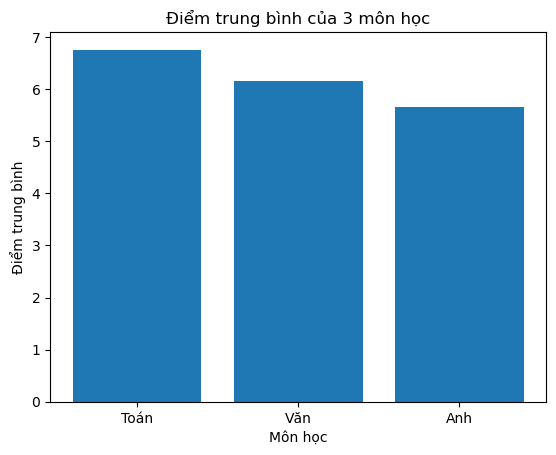

In [5]:

# Vẽ biểu đồ cột cho 3 điểm Toán, Văn và Anh
plt.bar(['Toán', 'Văn', 'Anh'], [df['Điểm Toán'].mean(), df['Điểm Văn'].mean(), df['Điểm Anh'].mean()])
plt.xlabel('Môn học')
plt.ylabel('Điểm trung bình')
plt.title('Điểm trung bình của 3 môn học')
plt.show()


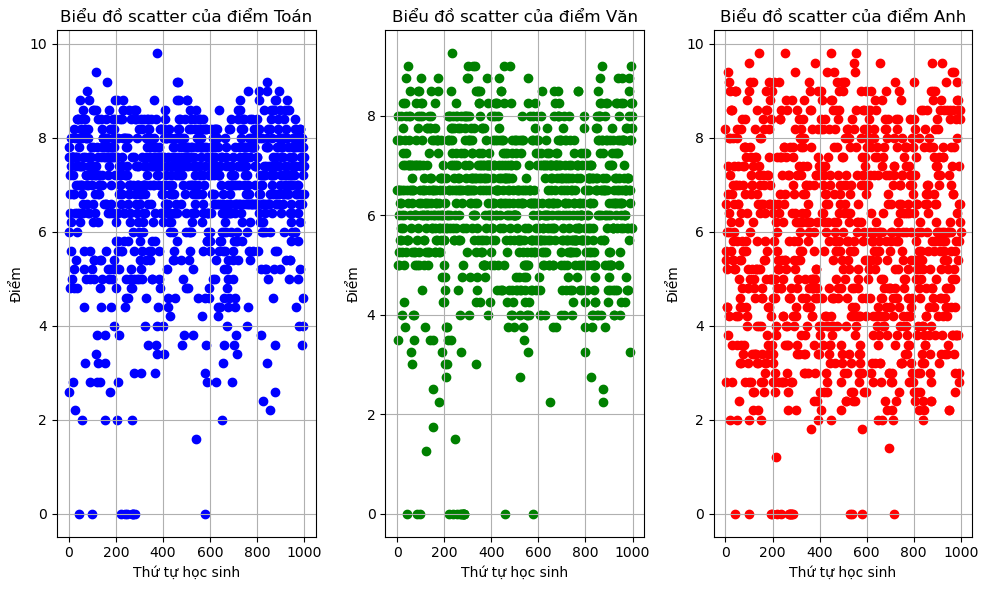

In [6]:

# Thiết lập kích thước và hình dạng của biểu đồ
plt.figure(figsize=(10, 6))

# Biểu đồ scatter cho điểm Toán
plt.subplot(1, 3, 1)
plt.scatter(range(len(df)), df['Điểm Toán'], color='blue', marker='o')
plt.title('Biểu đồ scatter của điểm Toán')
plt.xlabel('Thứ tự học sinh')
plt.ylabel('Điểm')
plt.grid(True)

# Biểu đồ scatter cho điểm Văn
plt.subplot(1, 3, 2)
plt.scatter(range(len(df)), df['Điểm Văn'], color='green', marker='o')
plt.title('Biểu đồ scatter của điểm Văn')
plt.xlabel('Thứ tự học sinh')
plt.ylabel('Điểm')
plt.grid(True)

# Biểu đồ scatter cho điểm Anh
plt.subplot(1, 3, 3)
plt.scatter(range(len(df)), df['Điểm Anh'], color='red', marker='o')
plt.title('Biểu đồ scatter của điểm Anh')
plt.xlabel('Thứ tự học sinh')
plt.ylabel('Điểm')
plt.grid(True)

plt.tight_layout()  # Để tránh trùng lấn giữa các biểu đồ
plt.show()


## 3.2 Dân số và mật độ dân số [2018 - 2022]

In [7]:

popu_path = r"..\DATA\RAW DATA\Dân số và mật độ dân số [2018-2022]\Population_of_provinces.csv"
# Đọc dữ liệu từ file CSV
data_pop = pd.read_csv(popu_path, encoding='utf-8', thousands=',')  # Đặt tên file CSV thực tế của bạn

# Hiển thị thông tin về dữ liệu
print(data_pop.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   Địa phương                            63 non-null     object
 1   Dân số trung bình (Nghìn người) 2018  63 non-null     object
 2   Mật độ dân số (Người/km2) 2018        63 non-null     object
 3   Dân số trung bình (Nghìn người) 2019  63 non-null     object
 4   Mật độ dân số (Người/km2) 2019        63 non-null     object
 5   Dân số trung bình (Nghìn người) 2020  63 non-null     object
 6   Mật độ dân số (Người/km2) 2020        63 non-null     object
 7   Dân số trung bình (Nghìn người) 2021  63 non-null     object
 8   Mật độ dân số (Người/km2) 2021        63 non-null     object
 9   Dân số trung bình (Nghìn người) 2022  63 non-null     object
 10  Mật độ dân số (Người/km2) 2022        63 non-null     object
dtypes: object(11)
memory usage: 5.5+ K

### Mật độ dân số

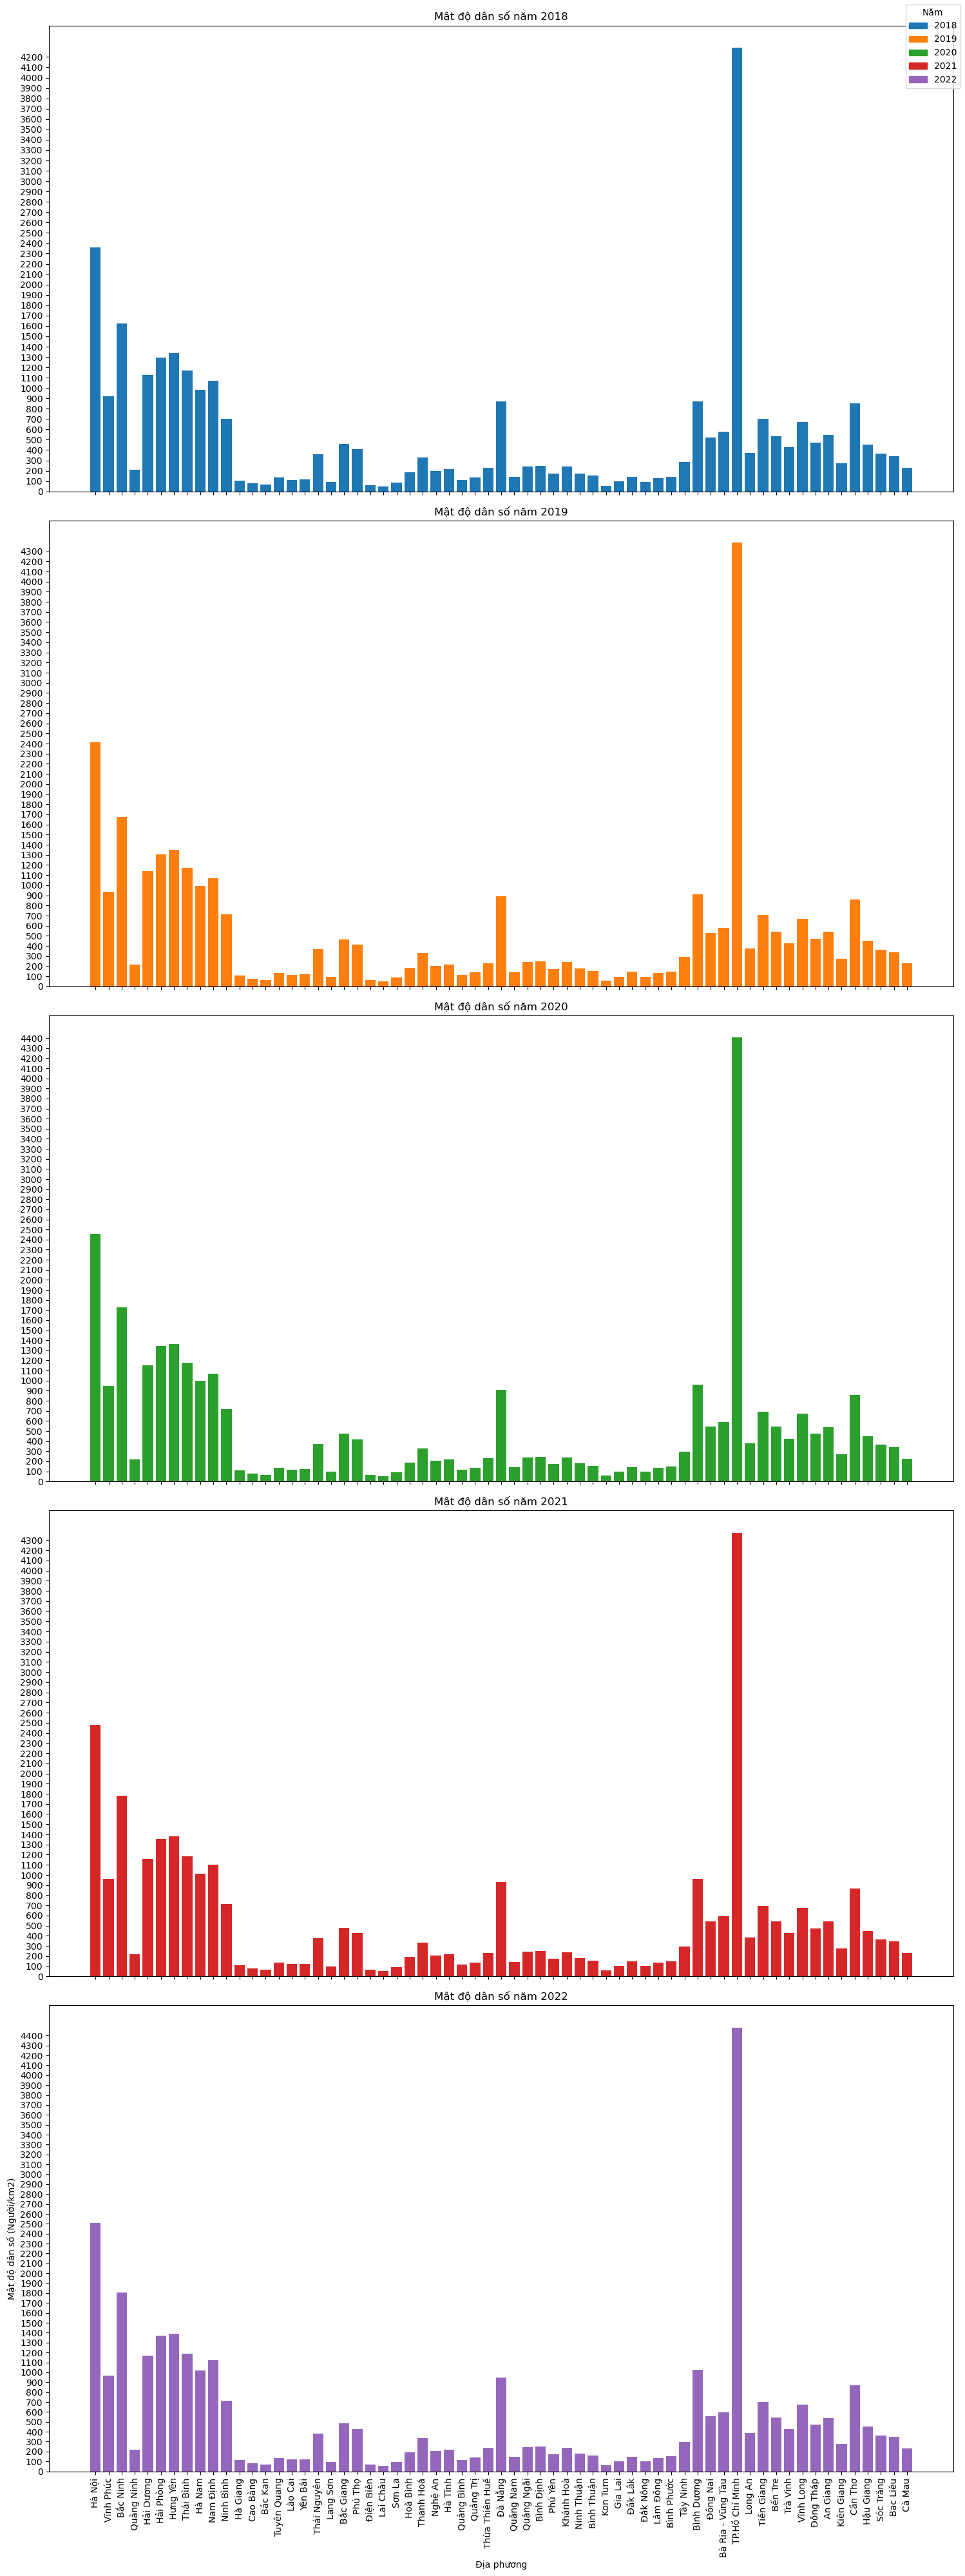

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Assuming data_pop is your DataFrame
data_pop = pd.read_csv(popu_path, encoding='utf-8', thousands=',')  # Đặt tên file CSV thực tế của bạn

# Convert data types from string to float
for column in data_pop.columns[1:]:
    data_pop[column] = data_pop[column].str.replace('.', '').str.replace(',', '.').astype(float)

# Create a colormap to use different colors for each year
colors = cm.tab10.colors

# Plot bar charts for each year from 2018 to 2022
fig, axs = plt.subplots(5, 1, figsize=(15, 40), sharex=True)
for i, year in enumerate(range(2018, 2023)):
    ax = axs[i]
    ax.set_title(f'Mật độ dân số năm {year}')
    ax.set_yticks(range(0, int(data_pop[f'Mật độ dân số (Người/km2) {year}'].max()) + 1, 100))
    for index, row in data_pop.iterrows():
        population_density = row[f'Mật độ dân số (Người/km2) {year}']
        ax.bar(row['Địa phương'], population_density, color=colors[i], label=row['Địa phương'])

# Add a legend for the years
legend_colors = [plt.Rectangle((0,0),1,1, color=color) for color in colors]
fig.legend(legend_colors, [str(year) for year in range(2018, 2023)], title='Năm', loc='upper right')

# Format the plot
plt.xlabel('Địa phương')
plt.ylabel('Mật độ dân số (Người/km2)')
plt.xticks(rotation=90)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()


### DÂN SỐ TRUNG BÌNH

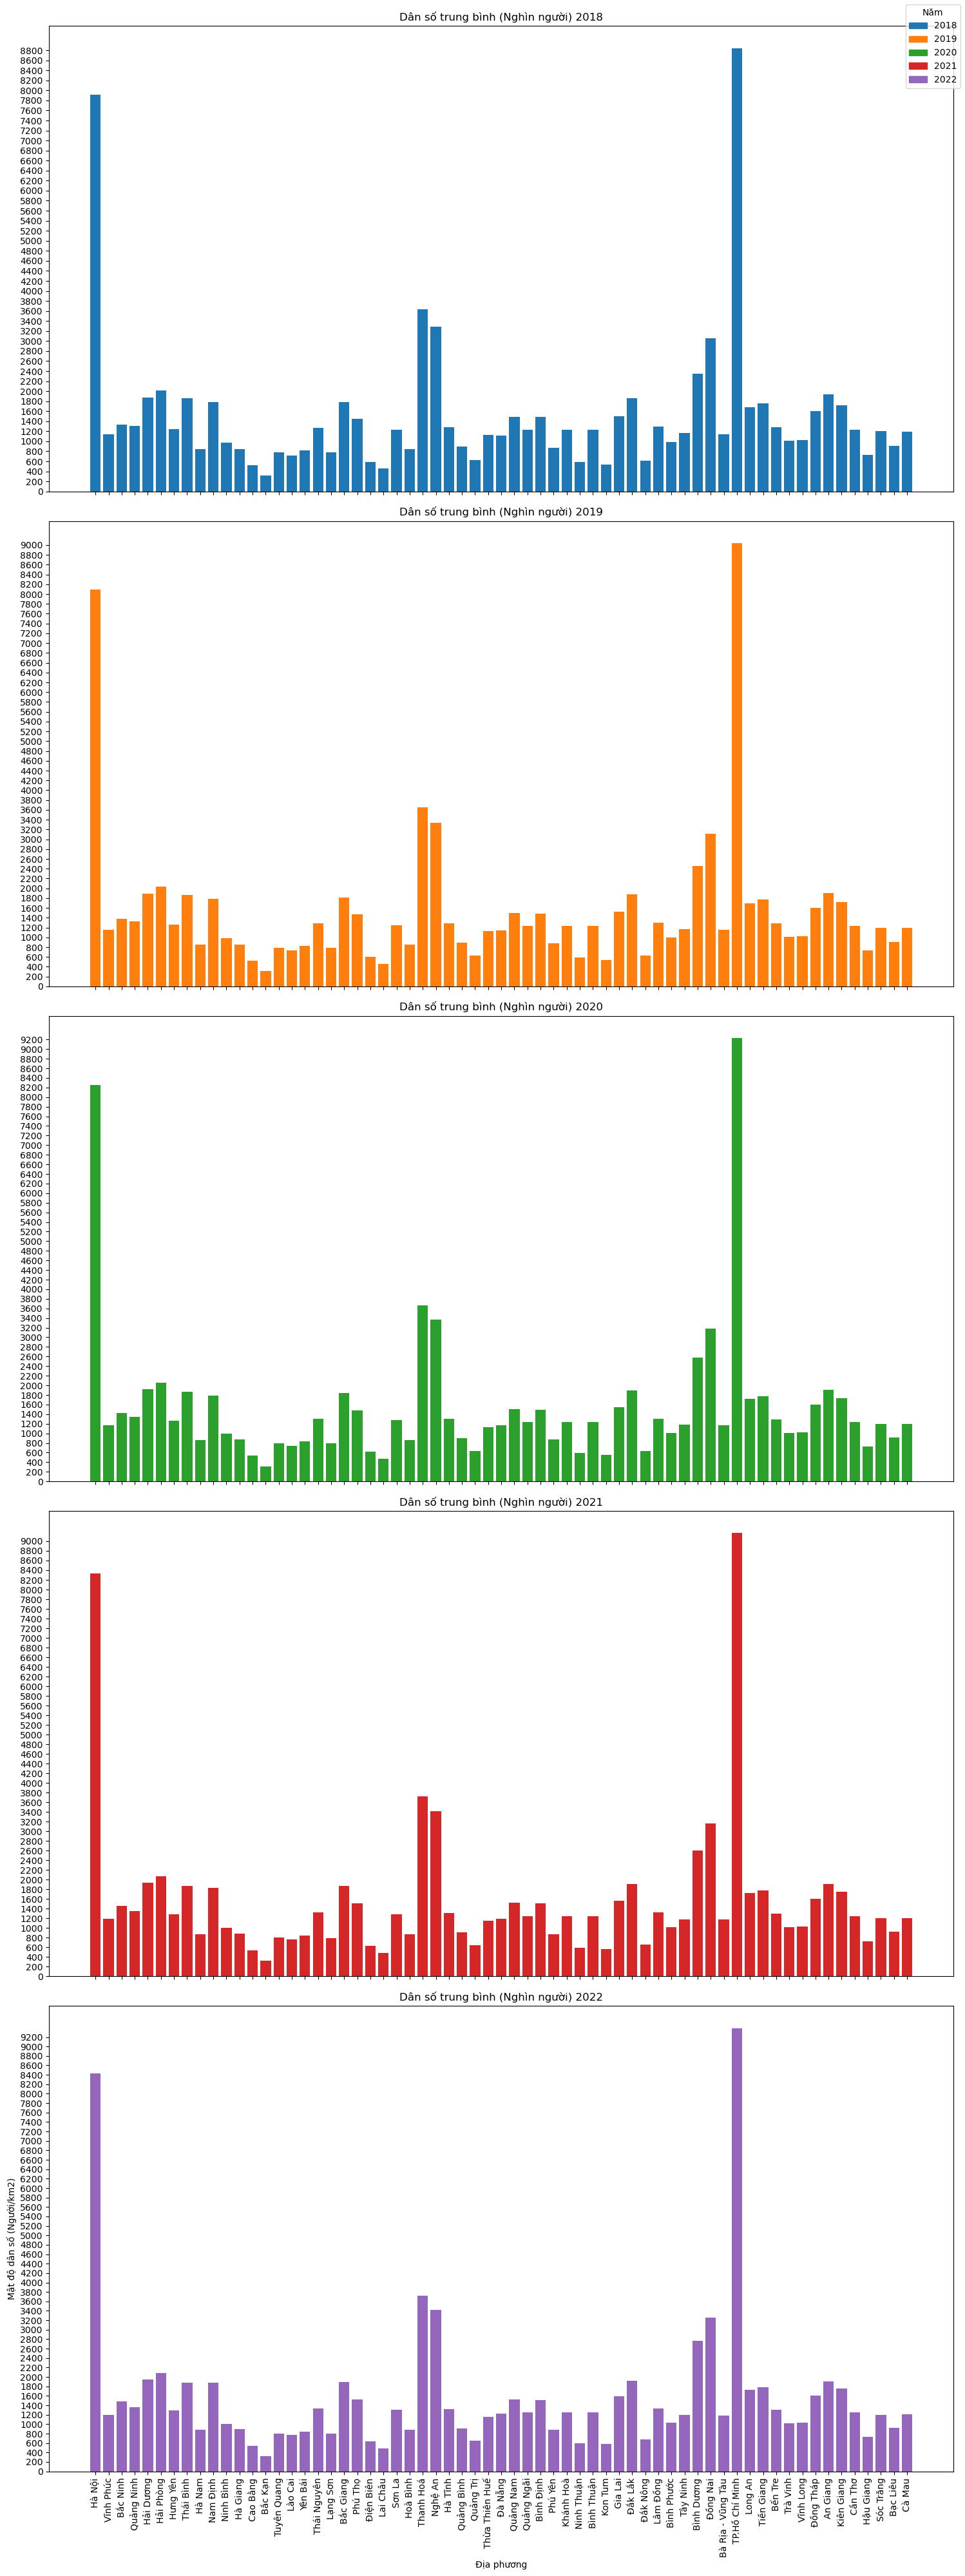

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Assuming data_pop is your DataFrame
data_pop = pd.read_csv(popu_path, encoding='utf-8', thousands=',')  # Đặt tên file CSV thực tế của bạn

# Convert data types from string to float
for column in data_pop.columns[1:]:
    data_pop[column] = data_pop[column].str.replace('.', '').str.replace(',', '.').astype(float)

# Create a colormap to use different colors for each year
colors = cm.tab10.colors

# Plot bar charts for each year from 2018 to 2022
fig, axs = plt.subplots(5, 1, figsize=(15, 40), sharex=True)
for i, year in enumerate(range(2018, 2023)):
    ax = axs[i]
    ax.set_title(f'Dân số trung bình (Nghìn người) {year}')
    ax.set_yticks(range(0, int(data_pop[f'Dân số trung bình (Nghìn người) {year}'].max()) + 1, 200))
    for index, row in data_pop.iterrows():
        population_density = row[f'Dân số trung bình (Nghìn người) {year}']
        ax.bar(row['Địa phương'], population_density, color=colors[i], label=row['Địa phương'])

# Add a legend for the years
legend_colors = [plt.Rectangle((0,0),1,1, color=color) for color in colors]
fig.legend(legend_colors, [str(year) for year in range(2018, 2023)], title='Năm', loc='upper right')

# Format the plot
plt.xlabel('Địa phương')
plt.ylabel('Mật độ dân số (Người/km2)')
plt.xticks(rotation=90)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()


## 3.3 Đầu tư giáo dục [2018 - 2022]

In [28]:
edu_invest = r"..\DATA\RAW DATA\Đầu tư giáo dục [2018-2023]\education.csv"
data_education_investment = pd.read_csv(edu_invest)

print(data_education_investment.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Địa phương             315 non-null    object
 1   Năm                    315 non-null    int64 
 2   Chi tiêu cho giáo dục  314 non-null    object
dtypes: int64(1), object(2)
memory usage: 7.5+ KB
None


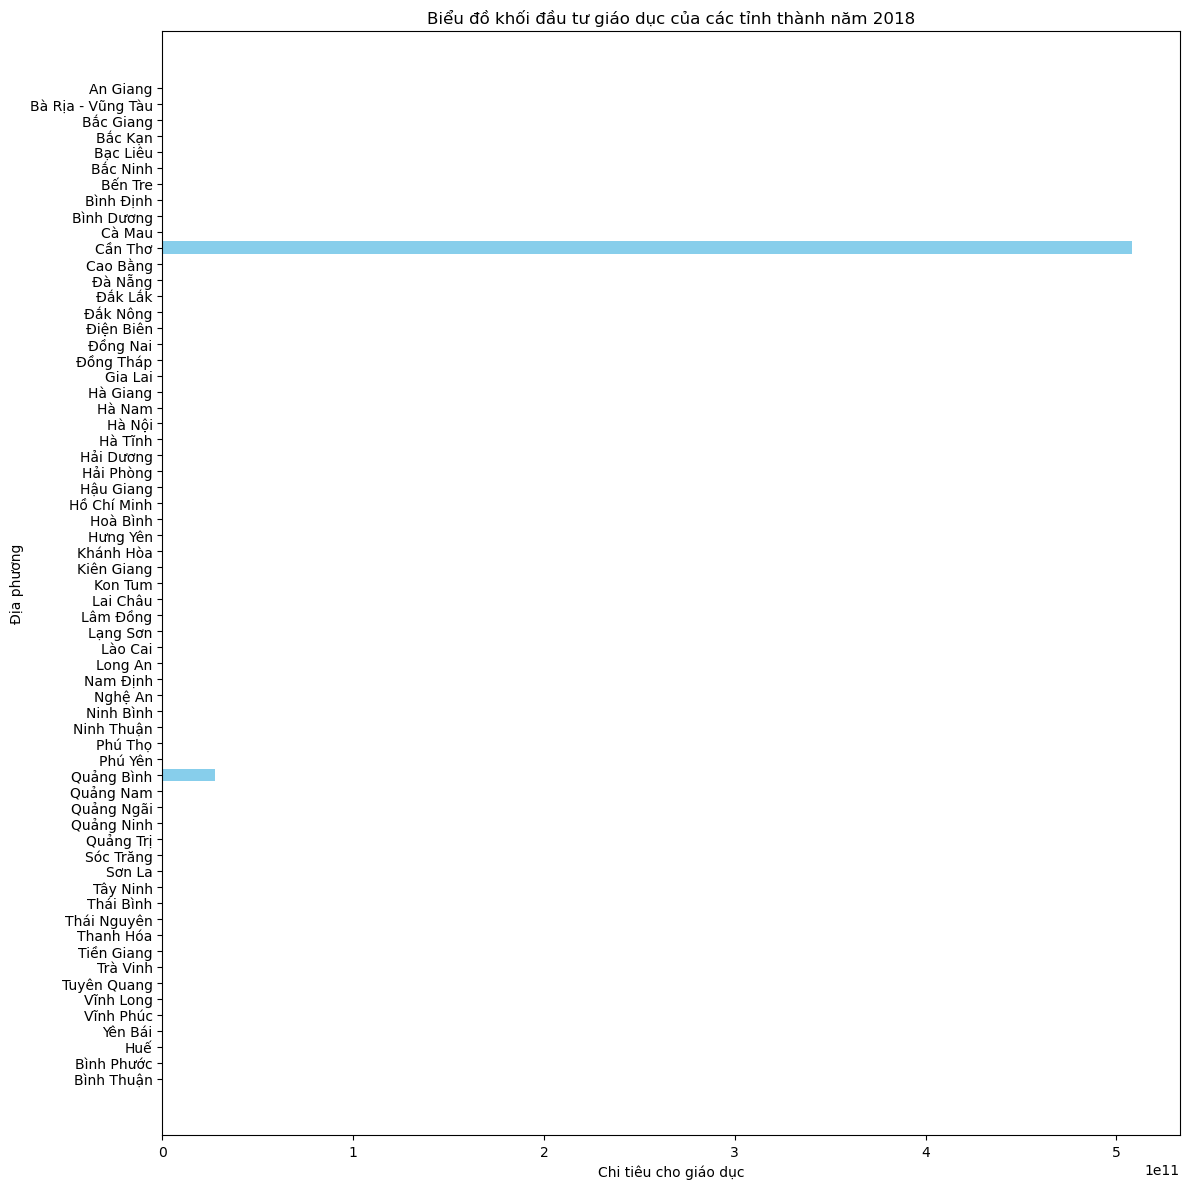

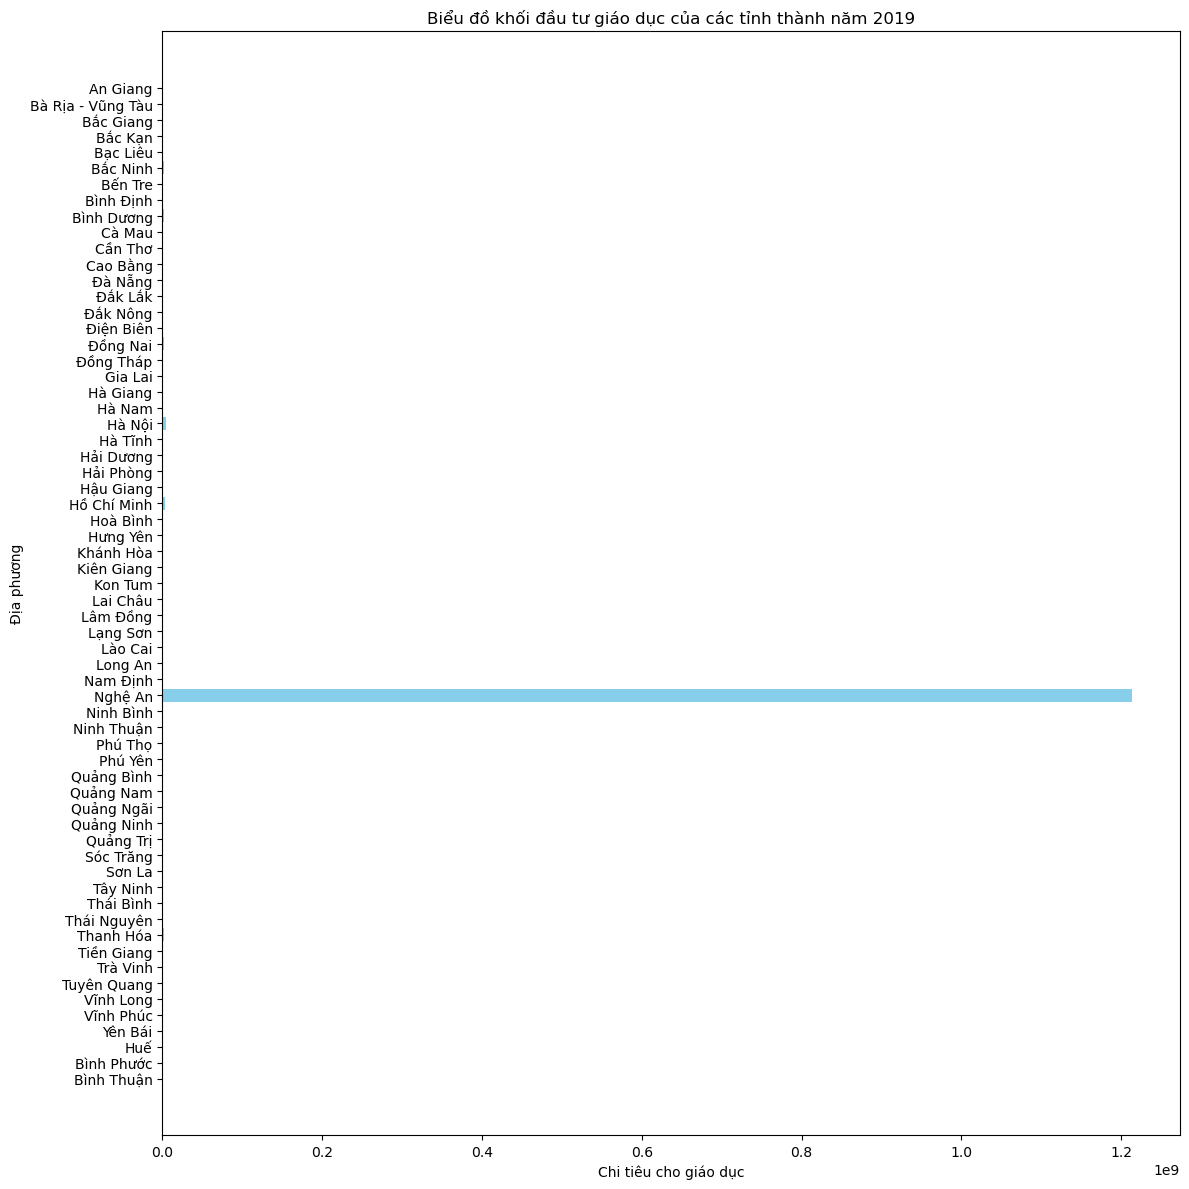

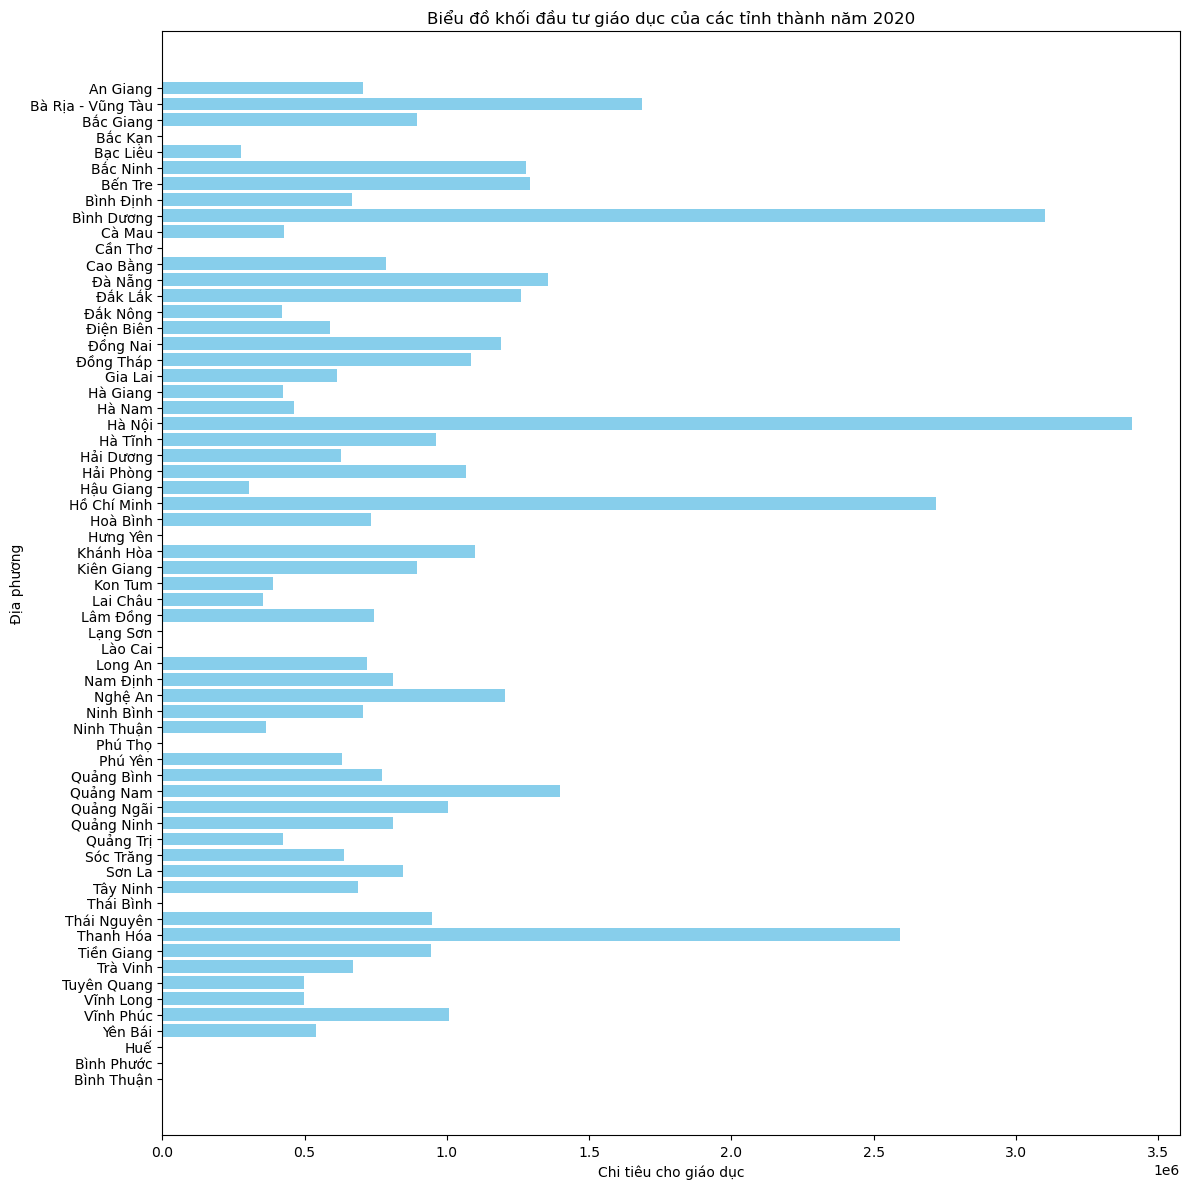

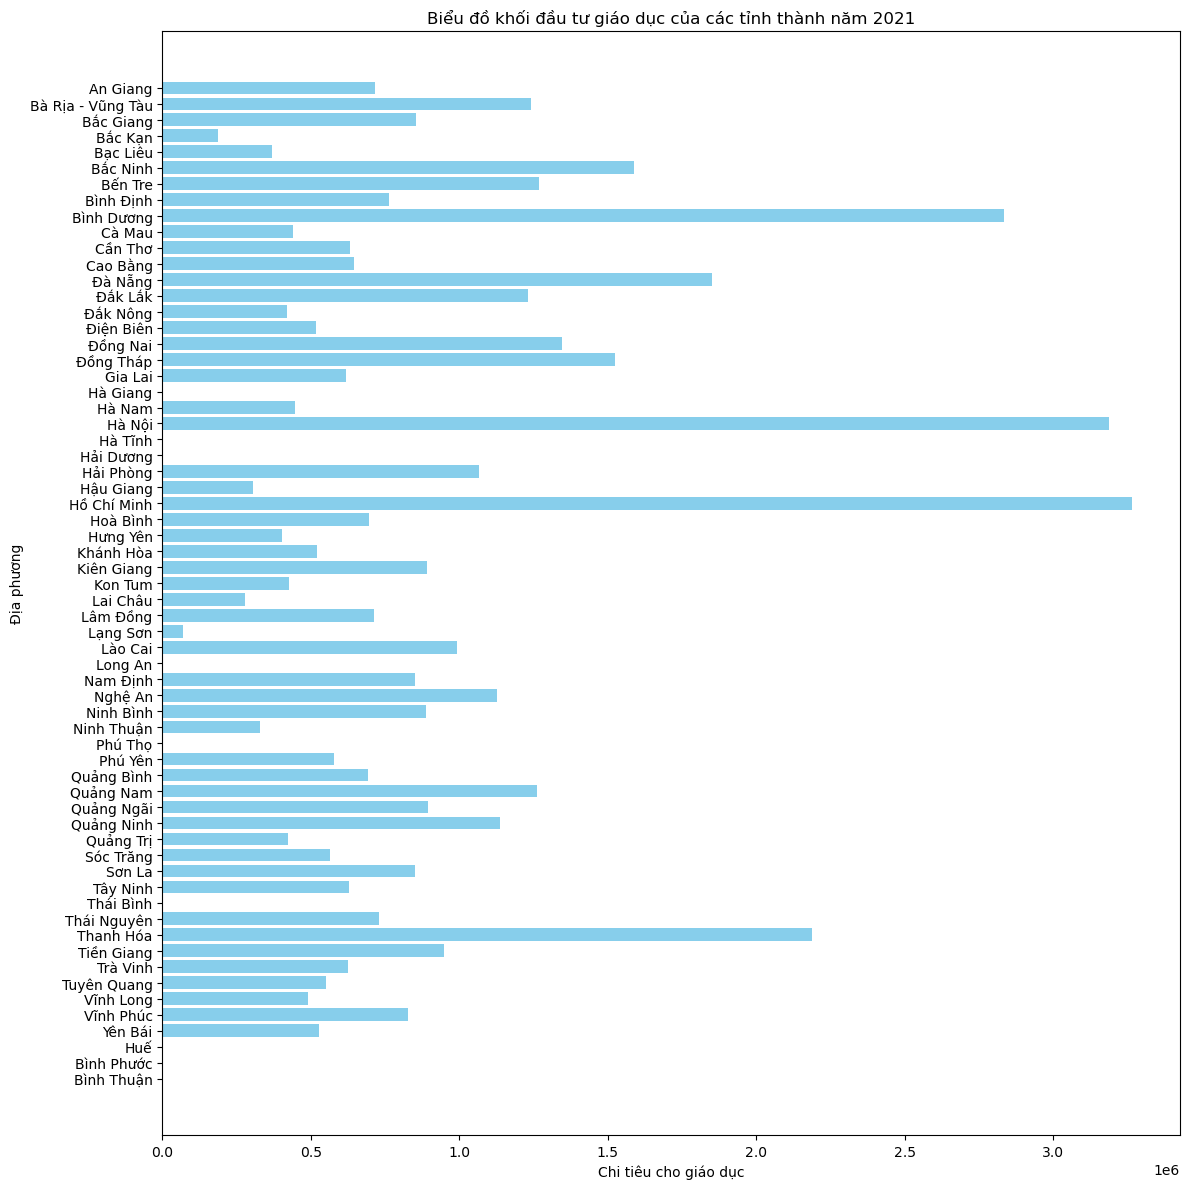

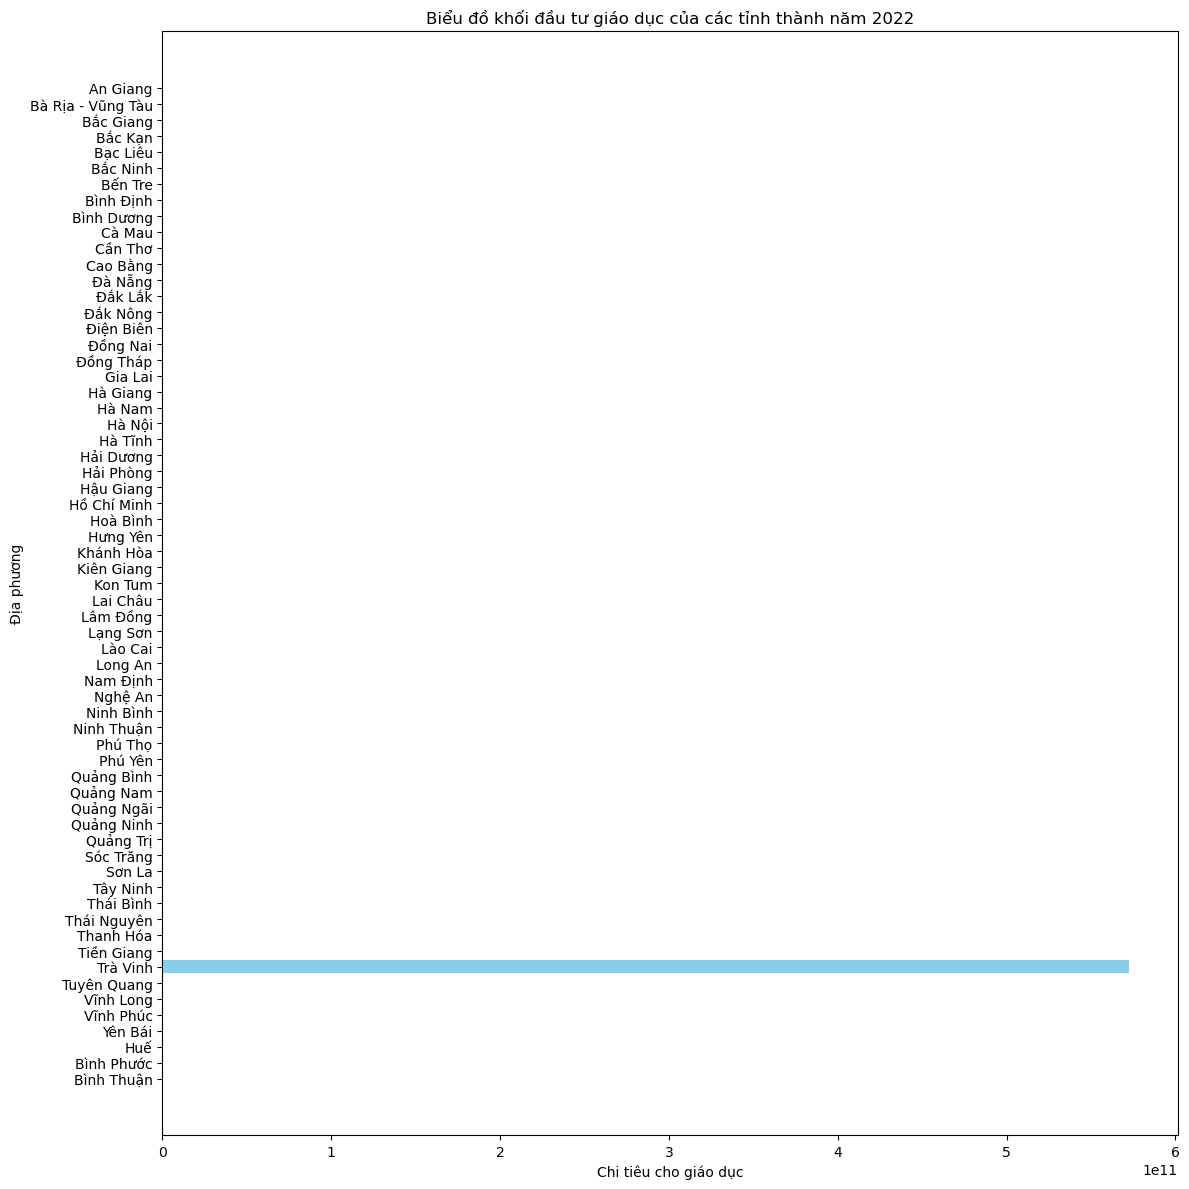

In [10]:

# Đọc dữ liệu từ file CSV
edu_invest = r"..\DATA\RAW DATA\Đầu tư giáo dục [2018-2023]\education.csv"
data_education_investment = pd.read_csv(edu_invest)



# Chuyển đổi các giá trị "-" thành 0 và chuyển cột "Chi tiêu cho giáo dục" từ chuỗi sang số
data_education_investment['Chi tiêu cho giáo dục'] = data_education_investment['Chi tiêu cho giáo dục'].replace('-', '0').str.replace('.', '').astype(float)

# Tạo danh sách các năm từ 2018 đến 2022
years = range(2018, 2023)

# Tạo 5 biểu đồ khối cho mỗi năm từ 2018 đến 2022
for year in years:
    # Lọc dữ liệu cho năm cụ thể
    year_data = data_education_investment[data_education_investment['Năm'] == year]
    
    # Tạo biểu đồ khối
    plt.figure(figsize=(12, 12))
    plt.barh(year_data['Địa phương'], year_data['Chi tiêu cho giáo dục'], color='skyblue')
    plt.xlabel('Chi tiêu cho giáo dục')
    plt.ylabel('Địa phương')
    plt.title(f'Biểu đồ khối đầu tư giáo dục của các tỉnh thành năm {year}')
    plt.gca().invert_yaxis()  # Đảo ngược trục y để hiển thị tỉnh thành trên đầu
    plt.tight_layout()
    plt.show()



## 3.4 Chỉ số giáo dục [2018 - 2020]

In [29]:
education_numeric_path = r"..\DATA\RAW DATA\Chỉ số giáo dục [2018-2020]\Thống kê chỉ số giai đoạn 2018 - 2020 - 12. Chỉ số giáo dục của cả nước và các địa phương giai đoạn 2018 - 2020.csv"
data_education_numeric = pd.read_csv(education_numeric_path)

print(data_education_numeric.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Địa phương  63 non-null     object
 1   2018        63 non-null     object
 2   2019        63 non-null     object
 3   2020        63 non-null     object
dtypes: object(4)
memory usage: 2.1+ KB
None


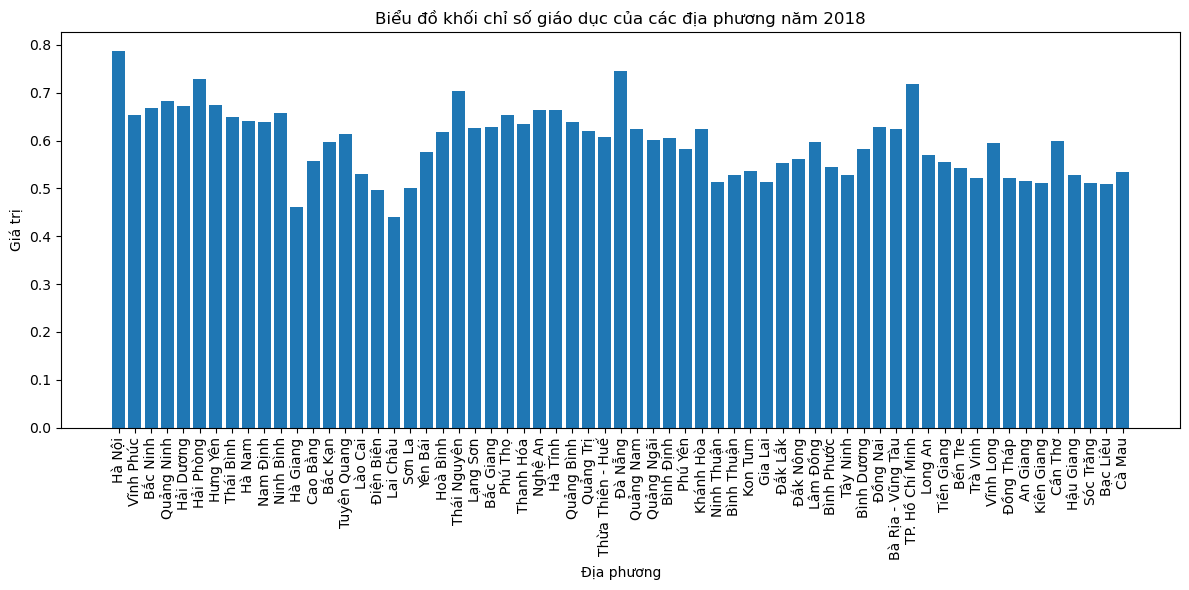

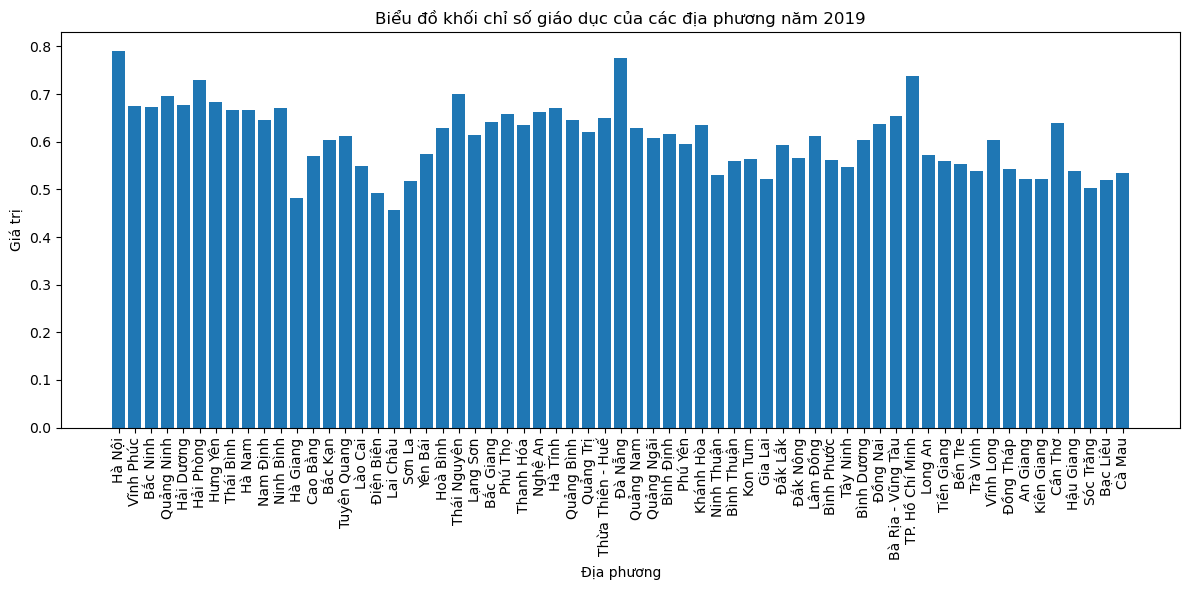

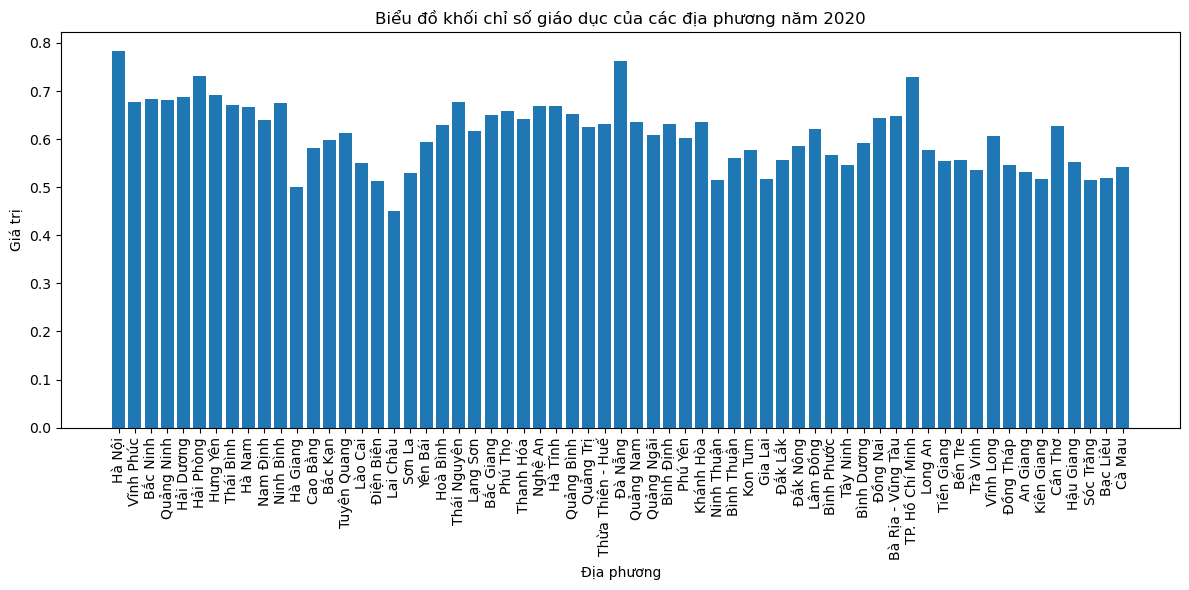

In [15]:

education_numeric_path = r"..\DATA\RAW DATA\Chỉ số giáo dục [2018-2020]\Thống kê chỉ số giai đoạn 2018 - 2020 - 12. Chỉ số giáo dục của cả nước và các địa phương giai đoạn 2018 - 2020.csv"
data_education_numeric = pd.read_csv(education_numeric_path)


for column in data_education_numeric.columns[1:]:
    data_education_numeric[column] = data_education_numeric[column].str.replace(',', '.').astype(float)

# Tạo danh sách các năm từ 2018 đến 2020
years = range(2018, 2021)

# Tạo 3 biểu đồ khối cho mỗi năm từ 2018 đến 2020
for year in years:
    # Lọc dữ liệu cho năm cụ thể
    year_data = data_education_numeric[['Địa phương', str(year)]]
    
    # Tạo biểu đồ khối
    plt.figure(figsize=(12, 6))
    plt.bar(year_data['Địa phương'], year_data[str(year)])
    plt.xlabel('Địa phương')
    plt.ylabel('Giá trị')
    plt.title(f'Biểu đồ khối chỉ số giáo dục của các địa phương năm {year}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


## 3.5 Chỉ số sức khỏe [2018 - 2020]

In [30]:

health_numeric_path = r"..\DATA\RAW DATA\Chỉ số sức khỏe [2018-2020]\Thống kê chỉ số giai đoạn 2018 - 2020 - 6. Chỉ số sức khỏe của cả nước và các địa phương giai đoạn 2018 - 2020.csv"
data_health_numeric = pd.read_csv(health_numeric_path)

print(data_health_numeric.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Địa phương  63 non-null     object
 1   2018        63 non-null     object
 2   2019        63 non-null     object
 3   2020        63 non-null     object
dtypes: object(4)
memory usage: 2.1+ KB
None


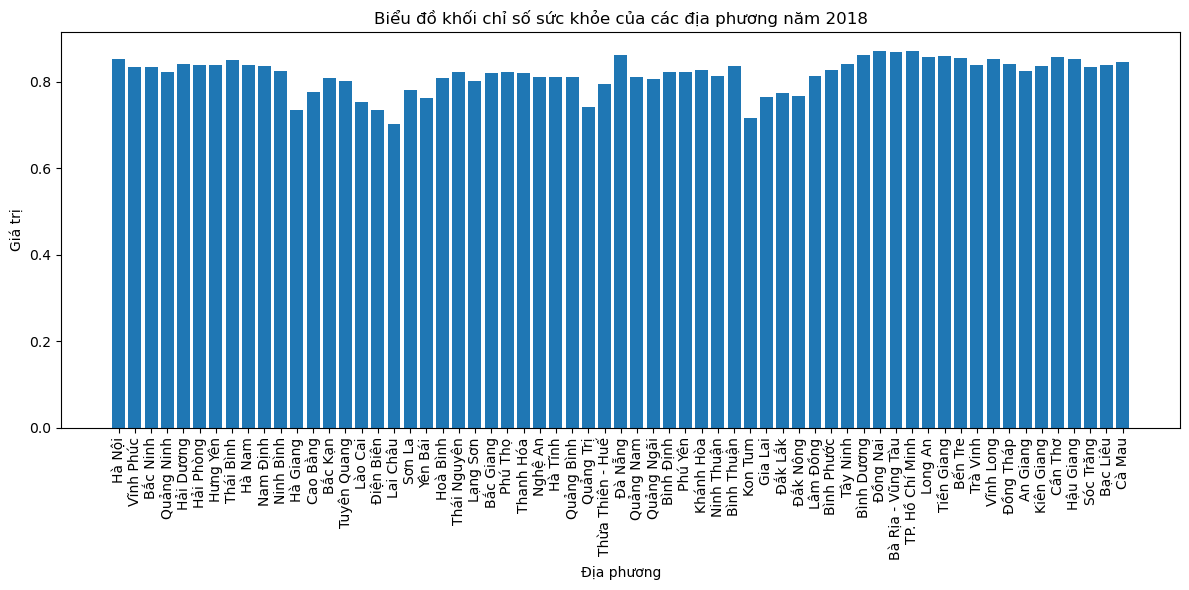

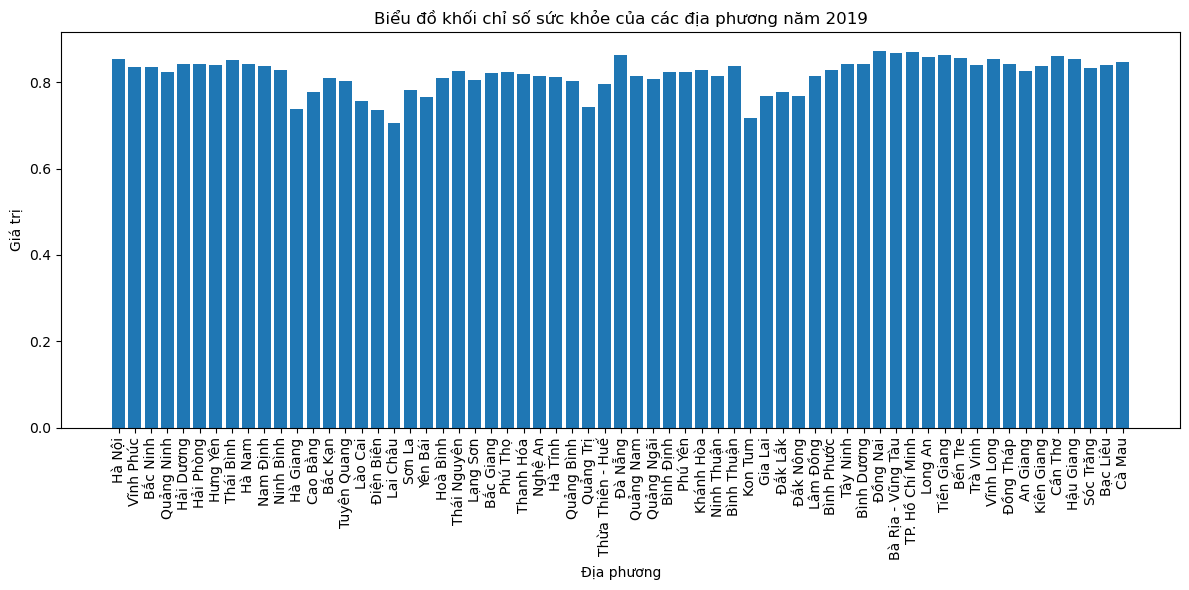

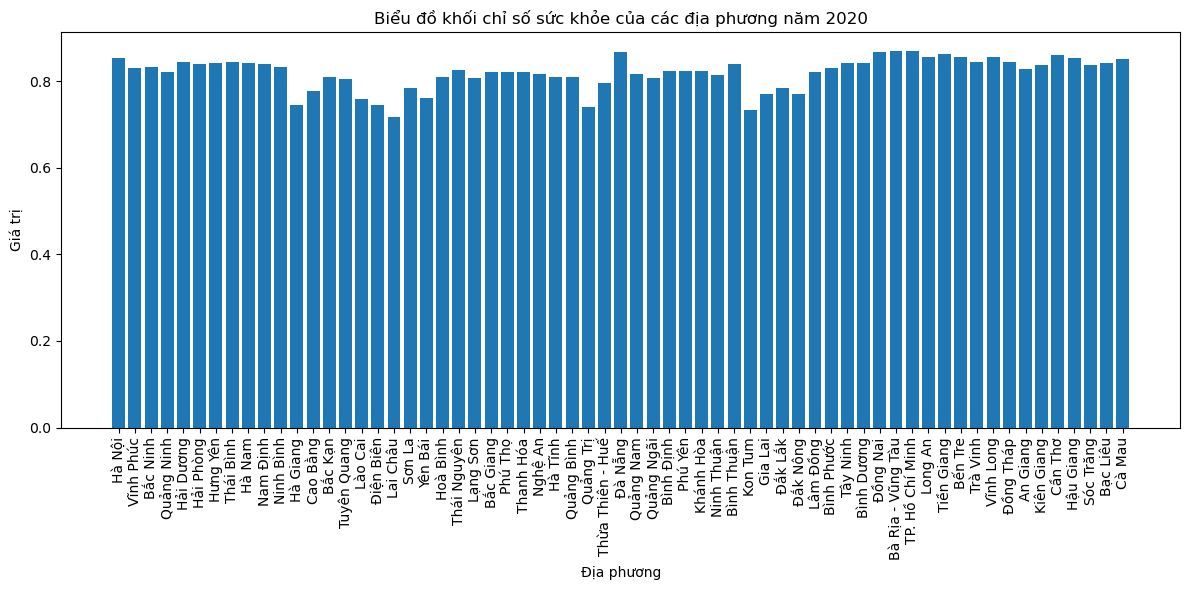

In [35]:

health_numeric_path = r"..\DATA\RAW DATA\Chỉ số sức khỏe [2018-2020]\Thống kê chỉ số giai đoạn 2018 - 2020 - 6. Chỉ số sức khỏe của cả nước và các địa phương giai đoạn 2018 - 2020.csv"
data_health_numeric = pd.read_csv(health_numeric_path)


for column in data_health_numeric.columns[1:]:
    data_health_numeric[column] = data_health_numeric[column].str.replace(',', '.').astype(float)

# Tạo danh sách các năm từ 2018 đến 2020
years = range(2018, 2021)

# Tạo 3 biểu đồ khối cho mỗi năm từ 2018 đến 2020
for year in years:
    # Lọc dữ liệu cho năm cụ thể
    year_data = data_health_numeric[['Địa phương', str(year)]]
    
    # Tạo biểu đồ khối
    plt.figure(figsize=(12, 6))
    plt.bar(year_data['Địa phương'], year_data[str(year)])
    plt.xlabel('Địa phương')
    plt.ylabel('Giá trị')
    plt.title(f'Biểu đồ khối chỉ số sức khỏe của các địa phương năm {year}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


## 3.6 Chỉ số thu nhập [2018 - 2020]

In [33]:
income_numeric_path = r"..\DATA\RAW DATA\Chỉ số thu nhập [2018-2020]\Thống kê chỉ số giai đoạn 2018 - 2020 - 16. Chỉ số thu nhập của cả nước và các địa phương giai đoạn 2018 - 2020.csv"
data_income_numeric = pd.read_csv(income_numeric_path)

print(data_income_numeric.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Địa phương  63 non-null     object
 1   2018        63 non-null     object
 2   2019        63 non-null     object
 3   2020        63 non-null     object
dtypes: object(4)
memory usage: 2.1+ KB
None


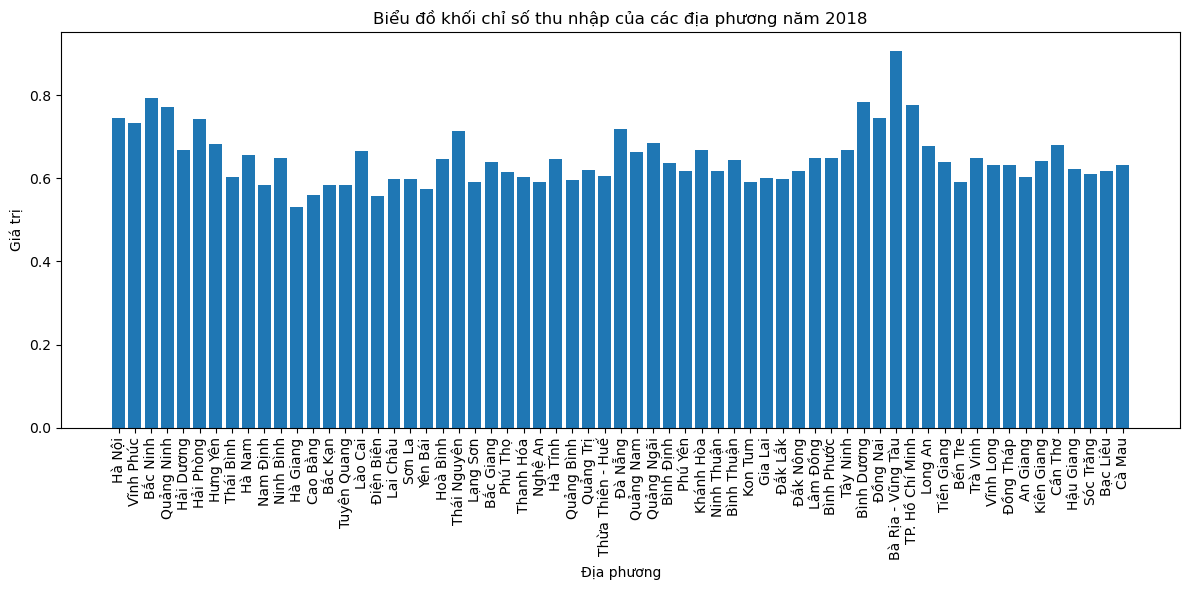

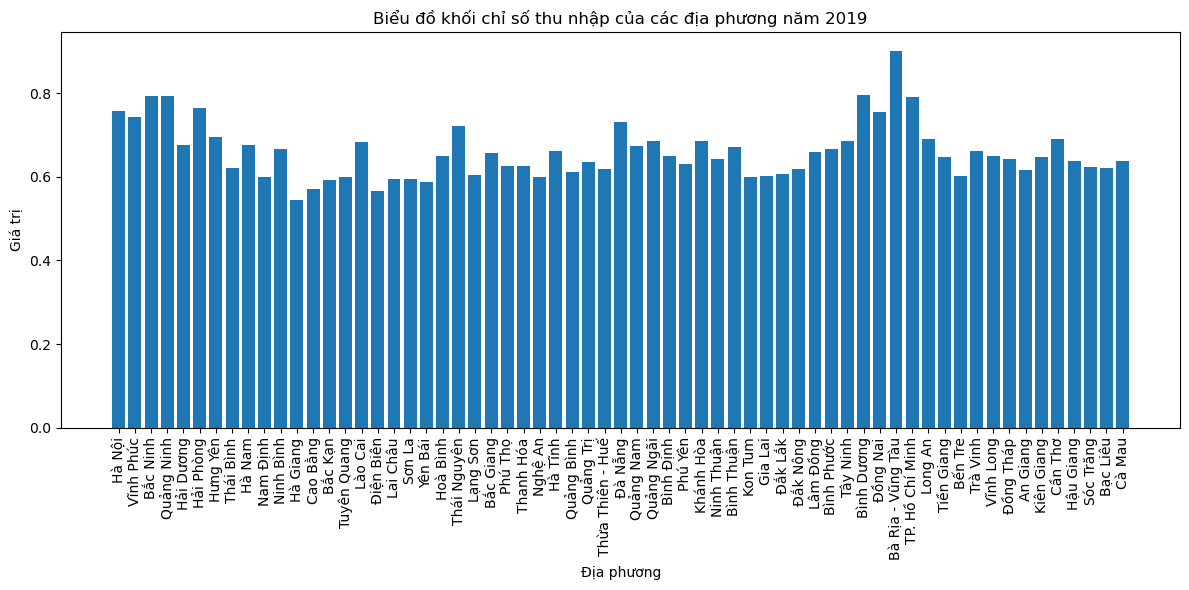

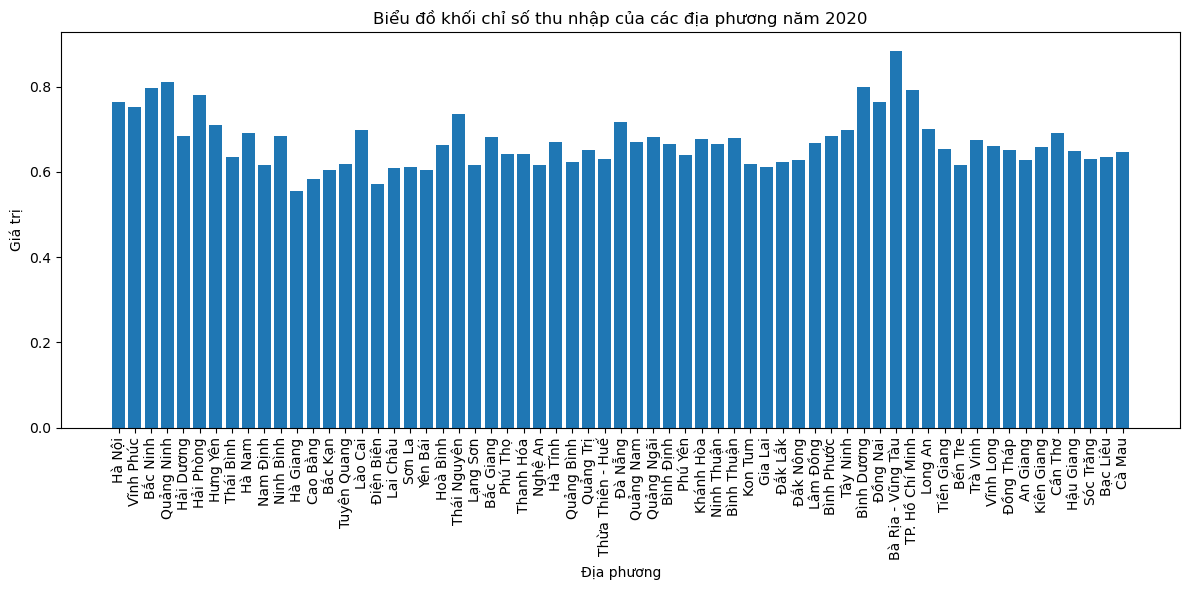

In [36]:

income_numeric_path = r"..\DATA\RAW DATA\Chỉ số thu nhập [2018-2020]\Thống kê chỉ số giai đoạn 2018 - 2020 - 16. Chỉ số thu nhập của cả nước và các địa phương giai đoạn 2018 - 2020.csv"
data_income_numeric = pd.read_csv(income_numeric_path)


for column in data_income_numeric.columns[1:]:
    data_income_numeric[column] = data_income_numeric[column].str.replace(',', '.').astype(float)

# Tạo danh sách các năm từ 2018 đến 2020
years = range(2018, 2021)

# Tạo 3 biểu đồ khối cho mỗi năm từ 2018 đến 2020
for year in years:
    # Lọc dữ liệu cho năm cụ thể
    year_data = data_income_numeric[['Địa phương', str(year)]]
    
    # Tạo biểu đồ khối
    plt.figure(figsize=(12, 6))
    plt.bar(year_data['Địa phương'], year_data[str(year)])
    plt.xlabel('Địa phương')
    plt.ylabel('Giá trị')
    plt.title(f'Biểu đồ khối chỉ số thu nhập của các địa phương năm {year}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()


## 3.7 Chỉ số phát triển con người [[2018 - 2020]]

In [37]:
development_numeric_path = r"..\DATA\RAW DATA\Chỉ số phát triển con người [2018-2020]\Thống kê chỉ số giai đoạn 2018 - 2020 - 1. Chỉ số phát triển con người của cả nước và các địa phương giai đoạn 2018 - 2020.csv"
data_development_numeric = pd.read_csv(development_numeric_path)

print(data_development_numeric.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Địa phương  63 non-null     object
 1   2018        63 non-null     object
 2   2019        63 non-null     object
 3   2020        63 non-null     object
dtypes: object(4)
memory usage: 2.1+ KB
None


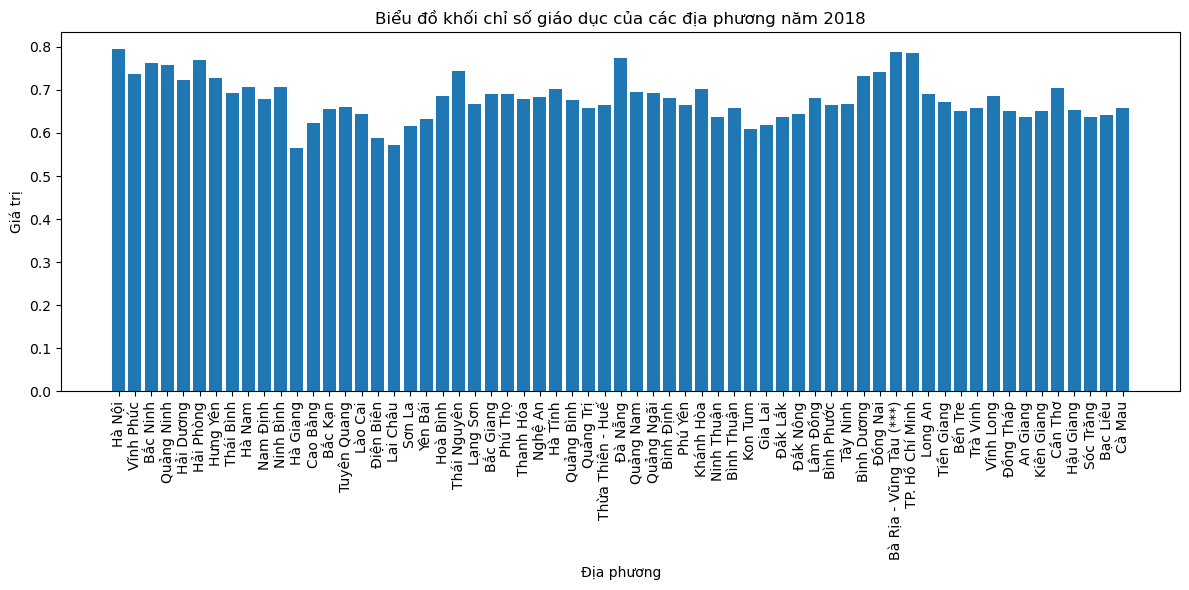

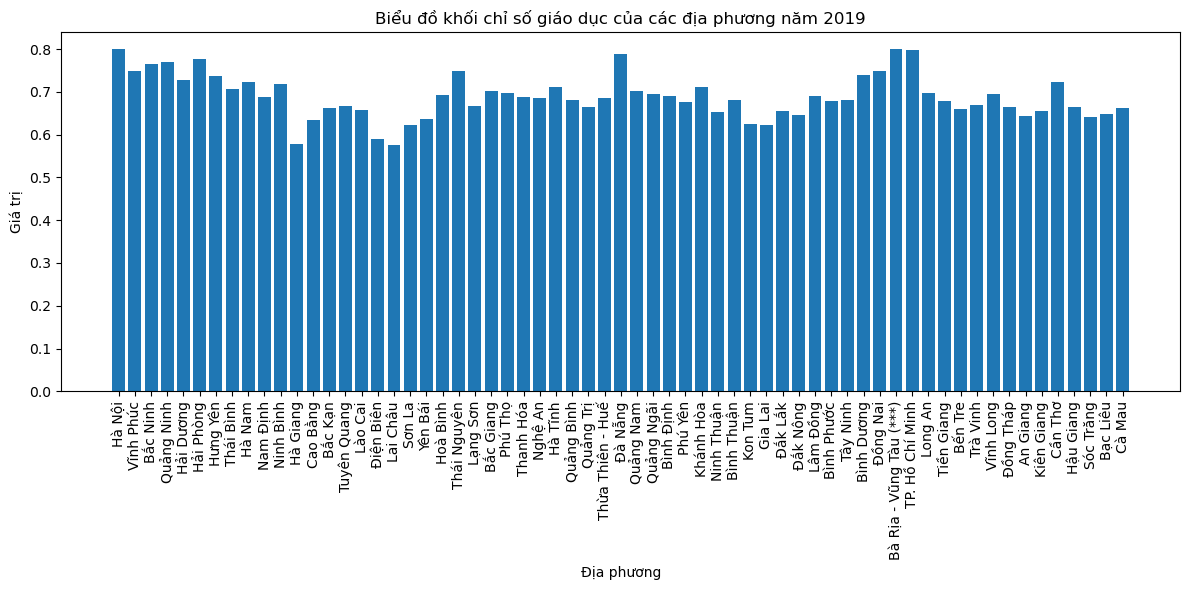

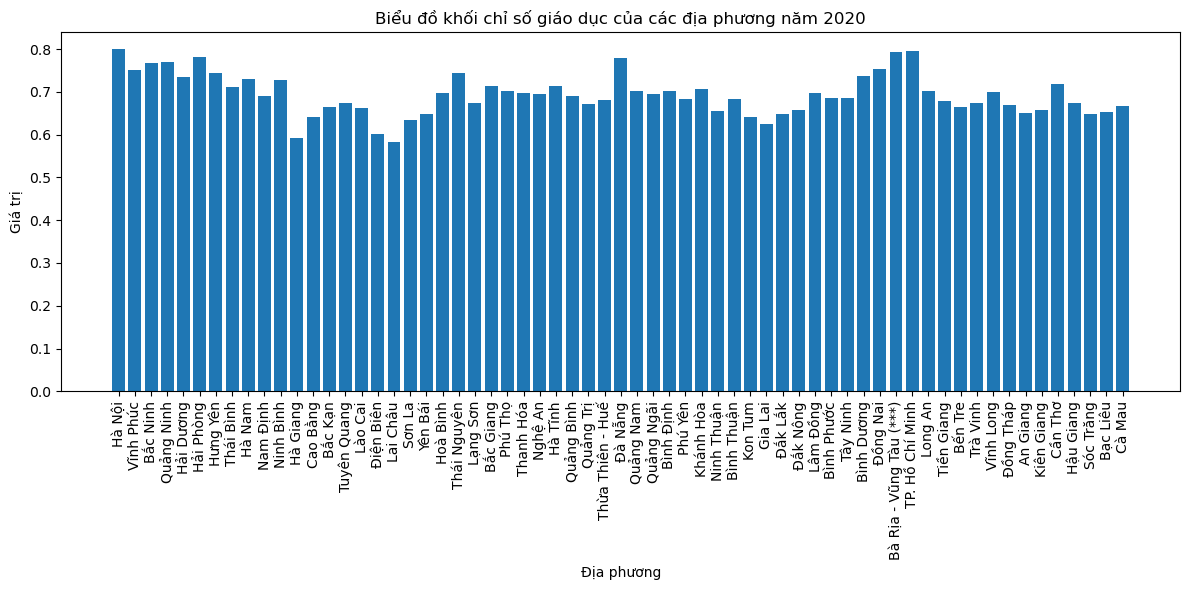

In [38]:

development_numeric_path = r"..\DATA\RAW DATA\Chỉ số phát triển con người [2018-2020]\Thống kê chỉ số giai đoạn 2018 - 2020 - 1. Chỉ số phát triển con người của cả nước và các địa phương giai đoạn 2018 - 2020.csv"
data_development_numeric = pd.read_csv(development_numeric_path)


for column in data_education_numeric.columns[1:]:
    data_development_numeric[column] = data_development_numeric[column].str.replace(',', '.').astype(float)

# Tạo danh sách các năm từ 2018 đến 2020
years = range(2018, 2021)

# Tạo 3 biểu đồ khối cho mỗi năm từ 2018 đến 2020
for year in years:
    # Lọc dữ liệu cho năm cụ thể
    year_data = data_development_numeric[['Địa phương', str(year)]]
    
    # Tạo biểu đồ khối
    plt.figure(figsize=(12, 6))
    plt.bar(year_data['Địa phương'], year_data[str(year)])
    plt.xlabel('Địa phương')
    plt.ylabel('Giá trị')
    plt.title(f'Biểu đồ khối chỉ số giáo dục của các địa phương năm {year}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
